## EDA on RNA/chromatin accessibility dynamics (real-time and pseudotime)

- Last updated: 6/4/2024
- Author: Yang-Joon Kim

- How the chromatin accessibilities change over time (0 somites to 30 somites)
- There are multiple ways to look at this. we'll summarize our attempts in EDA here.


### feature level
- **individual peaks (600K)**
- **gene.activity** (peaks were linked to each gene based on proximity to the promoter/TSS, or cicero-scores): there are a couple of choices - (1) Signac, (2) cicero, and (3) SEACells gene score. We'll choose **(1) Signac, and (2) cicero Gene.Activity score**, as we can compute these metrics per dataset (without integrating/merging peaks).

### cell grouping level
- **Metacells (SEAcells)**
- **all cells (per dataset)**
- single cells

We will try out a couple of combinations. Ultimately, we'd like to automate this process for any count matrices (however they were computed - metacells-by-gene.activity, for example).

- First, we decide on which count matrice (cells-by-features) we'll use. 
- Second, we will prepare the count matrices by aggregating over either all cells or metaclles. 
- Third, we will generate features-by-time matrix (there can be the third dimension of Metacells).
- EDA1: cluster the matrix to see if there's a trend in terms of features over time (i.e. gene.activity going up, going down, etc.)

- EDA2: 



In [66]:
# 0. Import
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
%matplotlib inline
from scipy import sparse
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.stats import zscore

In [3]:
# figure parameter setting
mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default

# Editable text and proper LaTeX fonts in illustrator
# matplotlib.rcParams['ps.useafm'] = True
# Editable fonts. 42 is the magic number
mpl.rcParams['pdf.fonttype'] = 42
sns.set(style='whitegrid', context='paper')

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')



In [8]:
# define the figure path
figpath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/RNA_ATAC_dynamics/"
os.makedirs(figpath, exist_ok=True)


## Step 1. RNA dynamics along the real-time (developmental stages)

In [4]:
# import the adata to find N highly variable genes
adata_RNA = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_RNA_ATAC_counts_RNA_master_filtered.h5ad")
adata_RNA

AnnData object with n_obs × n_vars = 94562 × 32057
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS_enrichment', 'TSS_percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT_weight', 'peaks_merged_weight', 'nCount_Gene_Activity', 'nFeature_Gene_Activity', 'nCount_peaks_integrated', 'nFeature_peaks_integrated', 'dataset', 'integrated_weight', 'peaks_integrated_weight', 'wsnn_res_0_8', 'seurat_clusters', 'data_source', 'annotation_ML', 'scANVI_zscape', 'annotation_ML_coarse', 'dev_stage'
    var: 'features'
    uns: 'annotation_ML_coarse_colors', 'annotation_ML_colors', 'dataset_colors', 'global_annotation_colors', 'log1p', 'scANVI_zscape_colors'
    obsm: 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'
    layers: 'counts'

In [5]:
# compute N highly variable genes
N_top_genes = 3000
sc.pp.highly_variable_genes(adata_RNA, layer="counts", 
                            n_top_genes=N_top_genes, flavor="seurat_v3")

In [6]:
# extract the list of highly variable genes
list_hvg_RNA = adata_RNA.var_names[adata_RNA.var.highly_variable==True]

# check if some of the marker genes are present in the list of highly variable genes
print("myf5" in list_hvg_RNA)
print("meox1" in list_hvg_RNA)
print("sox2" in list_hvg_RNA)
print("tbxta" in list_hvg_RNA)

True
True
False
True


In [9]:
# In R, we should have computed the highly variable peaks using "FindTopFeatures" in Signac library.

# # compute highly variable peaks (feature-selection)
# # we need this as there are 600K peaks, and that's a little too much to assess
# sc.pp.highly_variable_genes(integrated_atac, n_top_genes=3000, )

In [11]:
# create a dataframe of cells-by-gene.activity (Signac)
count_matrice = pd.DataFrame(adata_RNA.X.todense(),
                             index=adata_RNA.obs.index,
                             columns=adata_RNA.var_names)
count_matrice.head()

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-nd4,NC-002333.16,NC-002333.15,NC-002333.8,mt-nd5,mt-nd6,NC-002333.21,mt-cyb,NC-002333.22,NC-002333.11
AAACAGCCACCTAAGC-1_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,2.965235,0.000000,0.0,0.0,0.929512,0.000000,0.0,3.298264,0.0,0.0
AAACAGCCAGGGAGGA-1_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,3.028786,0.000000,0.0,0.0,1.778004,0.970531,0.0,4.121566,0.0,0.0
AAACAGCCATAGACCC-1_1,0.0,0.0,0.0,0.0,0.584921,0.0,0.0,0.0,0.0,0.0,...,3.274696,0.000000,0.0,0.0,1.219220,1.219220,0.0,3.917621,0.0,0.0
AAACATGCAAACTCAT-1_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,2.453977,1.019721,0.0,0.0,1.019721,0.000000,0.0,4.115165,0.0,0.0
AAACATGCAAGGACCA-1_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,2.974532,0.000000,0.0,0.0,2.497187,0.000000,0.0,4.101940,0.0,0.0


In [14]:
# transfer the "dataset" category labels to count_matrice df
count_matrice["dataset"] = adata_RNA.obs["dataset"]
count_matrice["annotation_ML_coarse"] = adata_RNA.obs["annotation_ML_coarse"]

In [12]:
# # transfer the "global_annotation" category labels to count_matrice df

# # Let's say you want to keep the part of the index before the first underscore
# trimmed_indices = adata_RNA.obs.index.str.split('_').str[0]

# # Now, use these trimmed indices to create a mapping from cell ID to cell type
# cell_id_to_celltype = dict(zip(trimmed_indices, adata_RNA.obs["annotation_ML_coarse"]))

# # Assuming that count_matrice.index contains the cell IDs without the additional string
# count_matrice["celltype"] = count_matrice.index.map(cell_id_to_celltype)

In [15]:
count_matrice.head()

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,NC-002333.15,NC-002333.8,mt-nd5,mt-nd6,NC-002333.21,mt-cyb,NC-002333.22,NC-002333.11,dataset,annotation_ML_coarse
AAACAGCCACCTAAGC-1_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.929512,0.000000,0.0,3.298264,0.0,0.0,TDR118,epidermis
AAACAGCCAGGGAGGA-1_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.778004,0.970531,0.0,4.121566,0.0,0.0,TDR118,pronephros
AAACAGCCATAGACCC-1_1,0.0,0.0,0.0,0.0,0.584921,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.219220,1.219220,0.0,3.917621,0.0,0.0,TDR118,hindbrain
AAACATGCAAACTCAT-1_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.019721,0.000000,0.0,4.115165,0.0,0.0,TDR118,axial_mesoderm
AAACATGCAAGGACCA-1_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.497187,0.000000,0.0,4.101940,0.0,0.0,TDR118,neural_optic


In [18]:
# add the "timepoints" category for the column

# define the dictionary for mapping
dict_timepoints = {"TDR126":"0somites",
                   "TDR127":"5somites",
                   "TDR128":"10somites",
                   "TDR118":"15somites",
                   "TDR119":"15somites",
                   "TDR125":"20somites",
                   "TDR124":"30somites"}

# map the "dataset" to "timepoints"
count_matrice["timepoints"] = count_matrice["dataset"].map(dict_timepoints)
count_matrice.head()

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,NC-002333.8,mt-nd5,mt-nd6,NC-002333.21,mt-cyb,NC-002333.22,NC-002333.11,dataset,annotation_ML_coarse,timepoints
AAACAGCCACCTAAGC-1_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.929512,0.000000,0.0,3.298264,0.0,0.0,TDR118,epidermis,15somites
AAACAGCCAGGGAGGA-1_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.778004,0.970531,0.0,4.121566,0.0,0.0,TDR118,pronephros,15somites
AAACAGCCATAGACCC-1_1,0.0,0.0,0.0,0.0,0.584921,0.0,0.0,0.0,0.0,0.0,...,0.0,1.219220,1.219220,0.0,3.917621,0.0,0.0,TDR118,hindbrain,15somites
AAACATGCAAACTCAT-1_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.019721,0.000000,0.0,4.115165,0.0,0.0,TDR118,axial_mesoderm,15somites
AAACATGCAAGGACCA-1_1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,2.497187,0.000000,0.0,4.101940,0.0,0.0,TDR118,neural_optic,15somites


In [31]:
count_matrice.timepoints.value_counts()

timepoints
15somites    25981
5somites     18963
20somites    17130
0somites     14970
10somites    10990
30somites     6528
Name: count, dtype: int64

In [32]:
# compute the pseudo-bulk averaged gene expression

# Compute the mean gene expression level across all cells per 'timepoints'
timepoints_by_genes = count_matrice.groupby('timepoints')[numeric_columns].mean()

# Display the result
print(timepoints_by_genes)

              ptpn12     phtf2   phtf2.1  CU856344.1  si:zfos-932h1.3  \
timepoints                                                              
0somites    0.004380  0.003705  0.003320    0.001046         0.003556   
10somites   0.003407  0.003258  0.007897    0.000528         0.006024   
15somites   0.007047  0.006020  0.015391    0.000928         0.007851   
20somites   0.002883  0.003371  0.007894    0.000151         0.003975   
30somites   0.001634  0.000957  0.003331    0.000442         0.002898   
5somites    0.004743  0.002856  0.004415    0.000512         0.003338   

              mansc1      lrp6    dusp16    crebl2     gpr19  ...    mt-nd4  \
timepoints                                                    ...             
0somites    0.000074  0.017872  0.030984  0.022127  0.080829  ...  1.920163   
10somites   0.000237  0.013377  0.035342  0.019646  0.018433  ...  2.624617   
15somites   0.000322  0.023251  0.034424  0.019784  0.004973  ...  2.465224   
20somites   0.000498

In [33]:
# compute the "standard errors" gene.activity across all cells per "timepoint" (TDR118 and TDR119 will be merged here)
timepoints_by_genes_sem = count_matrice.groupby('timepoints')[numeric_columns].sem()
timepoints_by_genes_sem.head()


,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-nd4,NC-002333.16,NC-002333.15,NC-002333.8,mt-nd5,mt-nd6,NC-002333.21,mt-cyb,NC-002333.22,NC-002333.11
timepoints,,,,,,,,,,,,,,,,,,,,,
0somites,0.000652,0.000572,0.000550,0.000321,0.000564,0.000074,0.001310,0.001703,0.001417,0.002697,...,0.007185,0.002544,0.001298,0.000316,0.007567,0.003859,0.000216,0.004170,0.000177,0.000333
10somites,0.000660,0.000616,0.001002,0.000245,0.000837,0.000168,0.001276,0.002070,0.001517,0.001485,...,0.007269,0.003384,0.002477,0.000405,0.008706,0.005403,0.000497,0.005114,0.000747,0.000526
15somites,0.000547,0.000502,0.000808,0.000188,0.000560,0.000127,0.001011,0.001197,0.000892,0.000456,...,0.004488,0.001189,0.001669,0.000185,0.005053,0.004353,0.000332,0.003426,0.000306,0.000324
20somites,0.000418,0.000459,0.000719,0.000090,0.000510,0.000180,0.000910,0.001302,0.001306,0.001001,...,0.004589,0.001601,0.000814,0.000100,0.005961,0.003675,0.000218,0.003326,0.000375,0.000271
30somites,0.000546,0.000413,0.000823,0.000267,0.000776,0.000347,0.000906,0.001698,0.002267,0.000945,...,0.009557,0.002647,0.001462,0.000295,0.008822,0.004341,0.000254,0.005969,0.000366,0.000242


In [34]:
# numeric_timepoints to re-order the rows (timepoints_by_genes)
timepoints_by_genes['numeric_timepoints'] = timepoints_by_genes.index.str.extract('(\d+)').astype(int).values
timepoints_by_genes['numeric_timepoints']

# Sort by the numeric timepoints to ensure correct order in plot
timepoints_by_genes_sorted = timepoints_by_genes.sort_values('numeric_timepoints')
timepoints_by_genes_sorted

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,NC-002333.16,NC-002333.15,NC-002333.8,mt-nd5,mt-nd6,NC-002333.21,mt-cyb,NC-002333.22,NC-002333.11,numeric_timepoints
timepoints,,,,,,,,,,,,,,,,,,,,,
0somites,0.004380,0.003705,0.003320,0.001046,0.003556,0.000074,0.017872,0.030984,0.022127,0.080829,...,0.071624,0.018036,0.001153,1.132921,0.173804,0.000566,3.424309,0.000327,0.001113,0
5somites,0.004743,0.002856,0.004415,0.000512,0.003338,0.000100,0.011550,0.025287,0.017725,0.026617,...,0.060307,0.019858,0.000813,1.389615,0.277636,0.001032,3.824268,0.001066,0.001641,5
10somites,0.003407,0.003258,0.007897,0.000528,0.006024,0.000237,0.013377,0.035342,0.019646,0.018433,...,0.097399,0.051797,0.001371,1.316862,0.278451,0.002157,3.791800,0.004432,0.002446,10
15somites,0.007047,0.006020,0.015391,0.000928,0.007851,0.000322,0.023251,0.034424,0.019784,0.004973,...,0.034206,0.066482,0.000809,1.354081,0.594386,0.002532,3.546123,0.002301,0.002751,15
20somites,0.002883,0.003371,0.007894,0.000151,0.003975,0.000498,0.012328,0.025435,0.026033,0.014746,...,0.039009,0.009621,0.000196,0.876079,0.226617,0.000641,3.959623,0.001997,0.001092,20
30somites,0.001634,0.000957,0.003331,0.000442,0.002898,0.000757,0.004137,0.015777,0.027330,0.004174,...,0.036010,0.010775,0.000481,0.530218,0.104261,0.000353,3.392559,0.000717,0.000242,30


In [35]:
# numeric_timepoints to re-order the rows (timepoints_by_genes_sem)
timepoints_by_genes_sem['numeric_timepoints'] = timepoints_by_genes_sem.index.str.extract('(\d+)').astype(int).values
timepoints_by_genes_sem['numeric_timepoints']

# Sort by the numeric timepoints to ensure correct order in plot
timepoints_by_genes_sem_sorted = timepoints_by_genes_sem.sort_values('numeric_timepoints')
timepoints_by_genes_sem_sorted

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,NC-002333.16,NC-002333.15,NC-002333.8,mt-nd5,mt-nd6,NC-002333.21,mt-cyb,NC-002333.22,NC-002333.11,numeric_timepoints
timepoints,,,,,,,,,,,,,,,,,,,,,
0somites,0.000652,0.000572,0.000550,0.000321,0.000564,0.000074,0.001310,0.001703,0.001417,0.002697,...,0.002544,0.001298,0.000316,0.007567,0.003859,0.000216,0.004170,0.000177,0.000333,0
5somites,0.000579,0.000437,0.000554,0.000178,0.000468,0.000072,0.000892,0.001321,0.001104,0.001350,...,0.002027,0.001173,0.000233,0.006418,0.004106,0.000257,0.002924,0.000277,0.000324,5
10somites,0.000660,0.000616,0.001002,0.000245,0.000837,0.000168,0.001276,0.002070,0.001517,0.001485,...,0.003384,0.002477,0.000405,0.008706,0.005403,0.000497,0.005114,0.000747,0.000526,10
15somites,0.000547,0.000502,0.000808,0.000188,0.000560,0.000127,0.001011,0.001197,0.000892,0.000456,...,0.001189,0.001669,0.000185,0.005053,0.004353,0.000332,0.003426,0.000306,0.000324,15
20somites,0.000418,0.000459,0.000719,0.000090,0.000510,0.000180,0.000910,0.001302,0.001306,0.001001,...,0.001601,0.000814,0.000100,0.005961,0.003675,0.000218,0.003326,0.000375,0.000271,20
30somites,0.000546,0.000413,0.000823,0.000267,0.000776,0.000347,0.000906,0.001698,0.002267,0.000945,...,0.002647,0.001462,0.000295,0.008822,0.004341,0.000254,0.005969,0.000366,0.000242,30


In [36]:
timepoints_by_genes_sorted.index

Index(['0somites', '5somites', '10somites', '15somites', '20somites',
       '30somites'],
      dtype='object', name='timepoints')

In [128]:
df = count_matrice.groupby("timepoints")
df

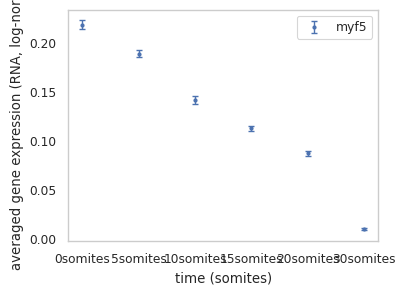

In [38]:
# Plotting the gene.activity dynamics (0-30 somites)
# define the gene
gene = "myf5"

# generate a plot
plt.figure(figsize=(4, 3))
plt.errorbar(timepoints_by_genes_sorted.index, 
             timepoints_by_genes_sorted[gene], 
             timepoints_by_genes_sem_sorted[gene],
             fmt='o', capsize=2, linestyle='None', 
             label=gene, markersize=2, elinewidth=1, capthick=1)
# plt.title('Scatter Plot of log-normalized counts over Timepoints')
plt.xlabel('time (somites)')
plt.ylabel('averaged gene expression (RNA, log-norm)')
plt.xticks(timepoints_by_genes_sorted.index)  # Show original timepoint labels
plt.legend()
plt.grid(False)
# plt.savefig(figpath + "gene_activity_score_myf5.pdf")
plt.show()

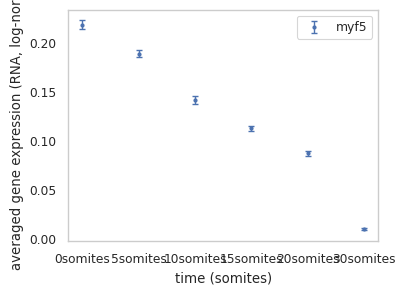

In [39]:
# Plotting the gene.activity dynamics (0-30 somites)
# define the gene
gene = "myf5"

# generate a plot
plt.figure(figsize=(4, 3))
plt.errorbar(timepoints_by_genes_sorted.index, 
             timepoints_by_genes_sorted[gene], 
             timepoints_by_genes_sem_sorted[gene],
             fmt='o', capsize=2, linestyle='None', 
             label=gene, markersize=2, elinewidth=1, capthick=1)
# plt.title('Scatter Plot of log-normalized counts over Timepoints')
plt.xlabel('time (somites)')
plt.ylabel('averaged gene expression (RNA, log-norm)')
plt.xticks(timepoints_by_genes_sorted.index)  # Show original timepoint labels
plt.legend()
plt.grid(False)
# plt.savefig(figpath + "gene_activity_score_myf5.pdf")
plt.show()

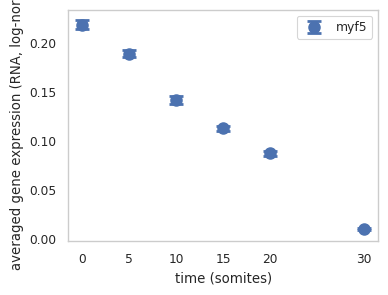

In [46]:
# Plotting the gene.activity dynamics (0-30 somites)
# define the gene
gene = "myf5"

# generate a plot
plt.figure(figsize=(4, 3))
plt.errorbar([0, 5, 10, 15, 20, 30], 
             timepoints_by_genes_sorted[gene], 
             timepoints_by_genes_sem_sorted[gene],
             fmt='o', capsize=5, linestyle='None', 
             label=gene, markersize=8, elinewidth=2, capthick=2)
# plt.title('Scatter Plot of log-normalized counts over Timepoints')
plt.xlabel('time (somites)')
plt.ylabel('averaged gene expression (RNA, log-norm)')
# plt.xticks(timepoints_by_genes_sorted.index)  # Show original timepoint labels
plt.xticks([0, 5, 10, 15, 20, 30])
plt.legend()
plt.grid(False)
plt.savefig(figpath + "RNA_timepoints_myf5.pdf")
plt.show()

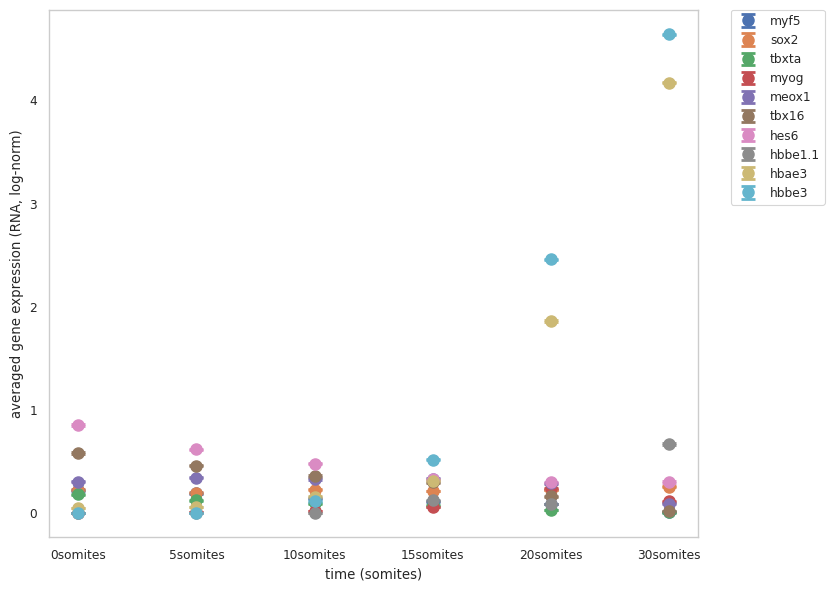

In [58]:
# Plotting the gene.activity dynamics (0-30 somites)
# define the gene
list_genes = ["myf5","sox2","tbxta","myog",
              "meox1","tbx16","hes6",
              "hbbe1.1","hbae3","hbbe3"]

# generate a plot
plt.figure(figsize=(10, 6))

for gene in list_genes:
    plt.errorbar(timepoints_by_genes_sorted.index, 
                 timepoints_by_genes_sorted[gene], 
                 timepoints_by_genes_sem_sorted[gene],
                 fmt='o', capsize=5, linestyle='None', 
                 label=gene, markersize=8, elinewidth=2, capthick=2)
    
# plt.title('Scatter Plot of log-normalized counts over Timepoints')
plt.xlabel('time (somites)')
plt.ylabel('averaged gene expression (RNA, log-norm)')
plt.xticks(timepoints_by_genes_sorted.index)  # Show original timepoint labels
# Move the legend outside of the plot to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect parameter to make room for the legend
plt.grid(False)
# plt.savefig(figpath + "RNA_timepoints_genesets.pdf")
plt.show()

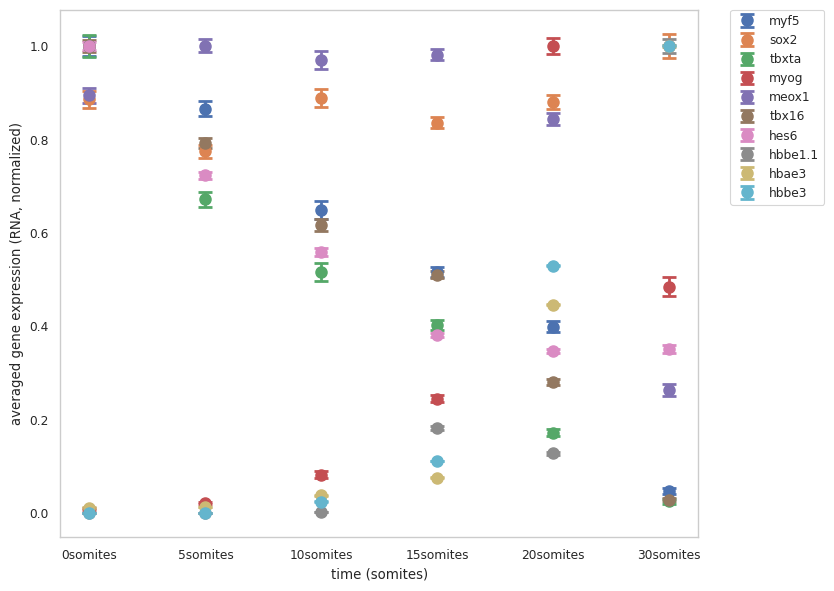

In [59]:
# Plotting the gene.activity dynamics (0-30 somites)
# define the gene
list_genes = ["myf5","sox2","tbxta","myog",
              "meox1","tbx16","hes6",
              "hbbe1.1","hbae3","hbbe3"]

# generate a plot
plt.figure(figsize=(10, 6))

for gene in list_genes:
    # Normalization step: divide by the max value to scale to 1
    normalized_values = timepoints_by_genes_sorted[gene] / timepoints_by_genes_sorted[gene].max()
    plt.errorbar(timepoints_by_genes_sorted.index, 
                 normalized_values, 
                 yerr=timepoints_by_genes_sem_sorted[gene] / timepoints_by_genes_sorted[gene].max(), 
                 fmt='o', capsize=5, linestyle='None', 
                 label=gene, markersize=8, elinewidth=2, capthick=2)
    
# plt.title('Scatter Plot of log-normalized counts over Timepoints')
plt.xlabel('time (somites)')
plt.ylabel('averaged gene expression (RNA, normalized)')
plt.xticks(timepoints_by_genes_sorted.index)  # Show original timepoint labels
# Move the legend outside of the plot to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect parameter to make room for the legend
plt.grid(False)
# plt.savefig(figpath + "gene_activity_score_genesets_normalized.pdf")
plt.show()

## Step 1. ATAC dynamics using cells-by-gene.activity (Signac)

- The gene.activity scores were computed by Signac for individual timepoints  (**using the "peaks_merged" for individual timepoints**, not "peaks_integrated" after the merge/integration over timepoints)
- We created a concatenated adata (all cells-by-gene.activity, with adata.obs having "dataset" identifiers)


In [7]:
# # filepath for all h5ad files and gene.activity count matrices
# data_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/"
# # list of all datasets
# list_datasets = ["TDR118reseq", "TDR119reseq", "TDR124reseq", "TDR125reseq",
#                  "TDR126", "TDR127", "TDR128"]


In [9]:
# # Initialize a list to hold the AnnData objects
# # Initialize a list to hold the AnnData objects
# adata_list = []

# # Loop to read each gene activity count matrix, convert to sparse, and store as an AnnData object
# for data in list_datasets:
#     # Read the count matrix and transpose it
#     count_matrix = pd.read_csv(data_path + data + "/gene_activity_counts.csv", index_col=0).transpose()
    
#     # Convert the DataFrame to a sparse matrix
#     sparse_matrix = sparse.csr_matrix(count_matrix.values)
    
#     # Create an AnnData object with the sparse_matrix as .X
#     adata_temp = sc.AnnData(X=sparse_matrix, obs=pd.DataFrame(index=count_matrix.index), var=pd.DataFrame(index=count_matrix.columns))
    
#     # Add the dataset label to .obs
#     adata_temp.obs["dataset"] = data
    
#     # Append the AnnData object to the list
#     adata_list.append(adata_temp)

# # Concatenate all AnnData objects in the list
# adata_gene_activity = sc.concat(adata_list, join='outer')


In [67]:
# Load the adata for cells-by-gene.activity (computed by Signac for all timepoints integrated - using the "peaks_integrated" for all timepoints)
adata_gene_activity = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_RNA_ATAC_counts_gene_activity.h5ad")
adata_gene_activity

MemoryError: Unable to allocate 5.60 GiB for an array with shape (751858126,) and data type float64

In [64]:
# save the raw gene.activity counts in "counts" layer
adata_gene_activity.layers["counts"] = adata_gene_activity.X.copy()

# log-normalization of the counts
sc.pp.normalize_total(adata_gene_activity, target_sum=1e4)
sc.pp.log1p(adata_gene_activity)

MemoryError: Unable to allocate 5.60 GiB for an array with shape (751858126,) and data type float64

In [9]:
adata_gene_activity

AnnData object with n_obs × n_vars = 95196 × 25032
    obs: 'dataset'
    uns: 'log1p'
    layers: 'counts'

In [10]:
# create a dataframe of cells-by-gene.activity (Signac)
count_matrice = pd.DataFrame(adata_gene_activity.X.todense(),
                             index=adata_gene_activity.obs.index,
                             columns=adata_gene_activity.var_names)
count_matrice.head()

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-co2,mt-atp8,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb
AAACAGCCACCTAAGC-1,0.0,0.0,0.0,0.000000,0.592085,0.0,0.000000,0.000000,0.00000,0.000000,...,3.053712,2.794065,3.127172,3.348628,3.290197,3.259649,3.505863,3.553223,2.932292,3.456149
AAACAGCCAGGGAGGA-1,0.0,0.0,0.0,0.000000,0.961259,0.0,0.961259,0.000000,0.00000,0.000000,...,3.933091,3.682853,3.797838,3.722669,3.455836,3.403520,3.760960,3.867750,2.509998,3.455836
AAACAGCCATAGACCC-1,0.0,0.0,0.0,0.324538,0.000000,0.0,0.000000,0.324538,0.56916,0.000000,...,2.494721,2.394998,2.613880,2.525868,2.462573,2.394998,2.613880,2.585395,1.789104,2.322525
AAACATGCAAACTCAT-1,0.0,0.0,0.0,0.000000,0.615839,0.0,0.000000,0.000000,0.00000,0.615839,...,2.937859,2.843336,2.891714,3.278512,3.245909,3.177330,3.580725,3.245909,2.417208,2.891714
AAACATGCAAGGACCA-1,0.0,0.0,0.0,0.000000,2.019401,0.0,0.000000,0.000000,0.00000,0.000000,...,3.693938,3.516579,3.844529,4.144265,4.144265,4.144265,4.414889,3.975383,3.172553,3.516579


In [11]:
# transfer the "dataset" category labels to count_matrice df
count_matrice["dataset"] = adata_gene_activity.obs["dataset"]

In [12]:
# transfer the "global_annotation" category labels to count_matrice df

# Let's say you want to keep the part of the index before the first underscore
trimmed_indices = adata_RNA.obs.index.str.split('_').str[0]

# Now, use these trimmed indices to create a mapping from cell ID to cell type
cell_id_to_celltype = dict(zip(trimmed_indices, adata_RNA.obs["global_annotation"]))

# Assuming that count_matrice.index contains the cell IDs without the additional string
count_matrice["celltype"] = count_matrice.index.map(cell_id_to_celltype)

In [13]:
count_matrice.head()

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb,dataset,celltype
AAACAGCCACCTAAGC-1,0.0,0.0,0.0,0.000000,0.592085,0.0,0.000000,0.000000,0.00000,0.000000,...,3.127172,3.348628,3.290197,3.259649,3.505863,3.553223,2.932292,3.456149,TDR118reseq,Epidermal
AAACAGCCAGGGAGGA-1,0.0,0.0,0.0,0.000000,0.961259,0.0,0.961259,0.000000,0.00000,0.000000,...,3.797838,3.722669,3.455836,3.403520,3.760960,3.867750,2.509998,3.455836,TDR118reseq,Lateral_Mesoderm
AAACAGCCATAGACCC-1,0.0,0.0,0.0,0.324538,0.000000,0.0,0.000000,0.324538,0.56916,0.000000,...,2.613880,2.525868,2.462573,2.394998,2.613880,2.585395,1.789104,2.322525,TDR118reseq,PSM
AAACATGCAAACTCAT-1,0.0,0.0,0.0,0.000000,0.615839,0.0,0.000000,0.000000,0.00000,0.615839,...,2.891714,3.278512,3.245909,3.177330,3.580725,3.245909,2.417208,2.891714,TDR118reseq,Neural_Posterior
AAACATGCAAGGACCA-1,0.0,0.0,0.0,0.000000,2.019401,0.0,0.000000,0.000000,0.00000,0.000000,...,3.844529,4.144265,4.144265,4.144265,4.414889,3.975383,3.172553,3.516579,TDR118reseq,Muscle


In [16]:
# add the "timepoints" category for the column

# define the dictionary for mapping
dict_timepoints = {"TDR126":"0somites",
                   "TDR127":"5somites",
                   "TDR128":"10somites",
                   "TDR118reseq":"15somites",
                   "TDR119reseq":"15somites",
                   "TDR125reseq":"20somites",
                   "TDR124reseq":"30somites"}

# map the "dataset" to "timepoints"
count_matrice["timepoints"] = count_matrice["dataset"].map(dict_timepoints)
count_matrice.head()

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb,dataset,celltype,timepoints
AAACAGCCACCTAAGC-1,0.0,0.0,0.0,0.000000,0.592085,0.0,0.000000,0.000000,0.00000,0.000000,...,3.348628,3.290197,3.259649,3.505863,3.553223,2.932292,3.456149,TDR118reseq,Epidermal,15somites
AAACAGCCAGGGAGGA-1,0.0,0.0,0.0,0.000000,0.961259,0.0,0.961259,0.000000,0.00000,0.000000,...,3.722669,3.455836,3.403520,3.760960,3.867750,2.509998,3.455836,TDR118reseq,Lateral_Mesoderm,15somites
AAACAGCCATAGACCC-1,0.0,0.0,0.0,0.324538,0.000000,0.0,0.000000,0.324538,0.56916,0.000000,...,2.525868,2.462573,2.394998,2.613880,2.585395,1.789104,2.322525,TDR118reseq,PSM,15somites
AAACATGCAAACTCAT-1,0.0,0.0,0.0,0.000000,0.615839,0.0,0.000000,0.000000,0.00000,0.615839,...,3.278512,3.245909,3.177330,3.580725,3.245909,2.417208,2.891714,TDR118reseq,Neural_Posterior,15somites
AAACATGCAAGGACCA-1,0.0,0.0,0.0,0.000000,2.019401,0.0,0.000000,0.000000,0.00000,0.000000,...,4.144265,4.144265,4.144265,4.414889,3.975383,3.172553,3.516579,TDR118reseq,Muscle,15somites


In [18]:
count_matrice.timepoints.value_counts()

15somites    26101
5somites     19138
20somites    17273
0somites     15036
10somites    11038
30somites     6610
Name: timepoints, dtype: int64

In [19]:
# compute the "mean" gene.activity across all cells per "timepoint" (TDR118 and TDR119 will be merged here)
timepoints_by_genes = count_matrice.groupby("timepoints").mean()
timepoints_by_genes

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-co2,mt-atp8,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb
timepoints,,,,,,,,,,,,,,,,,,,,,
0somites,0.143585,0.238076,0.120355,0.323444,0.850656,0.079996,0.181496,0.535486,0.463799,0.709817,...,2.977765,2.777127,2.961935,3.016140,2.886192,2.854369,3.188570,3.244055,2.528167,3.053888
10somites,0.155177,0.198876,0.099208,0.272355,0.728134,0.067494,0.167687,0.423641,0.353442,0.360416,...,2.938229,2.734809,2.918733,2.970474,2.833458,2.805676,3.142279,3.201706,2.484257,3.004827
15somites,0.123259,0.177863,0.093785,0.237302,0.613158,0.067831,0.139127,0.346035,0.280201,0.165483,...,2.911211,2.699371,2.896533,2.955707,2.836678,2.803241,3.125162,3.151262,2.412725,2.945002
20somites,0.132296,0.219326,0.116319,0.261235,0.762555,0.068222,0.165915,0.425418,0.375774,0.368629,...,3.117679,2.920023,3.105637,3.154313,3.017005,2.978828,3.302670,3.340081,2.623016,3.140953
30somites,0.095111,0.138486,0.079551,0.182402,0.707647,0.054272,0.140589,0.310097,0.228772,0.108782,...,3.733301,3.518038,3.713410,3.770773,3.643798,3.608102,3.937865,3.965087,3.213551,3.758859
5somites,0.150823,0.216179,0.108562,0.311532,0.783582,0.081726,0.182112,0.463511,0.372854,0.421533,...,3.389056,3.185097,3.374560,3.426672,3.289121,3.256618,3.598017,3.658834,2.929228,3.466786


In [69]:
# compute the "standard errors" gene.activity across all cells per "timepoint" (TDR118 and TDR119 will be merged here)
timepoints_by_genes_sem = count_matrice.groupby("timepoints").sem()
timepoints_by_genes_sem

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-co2,mt-atp8,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb
timepoints,,,,,,,,,,,,,,,,,,,,,
0somites,0.002169,0.002821,0.002056,0.003028,0.003909,0.001662,0.002422,0.003589,0.003357,0.003798,...,0.005747,0.005752,0.005751,0.005744,0.005738,0.005746,0.005724,0.005745,0.005723,0.005754
10somites,0.002728,0.003210,0.002277,0.003372,0.004766,0.001842,0.002831,0.004002,0.003667,0.003973,...,0.008043,0.008000,0.008051,0.008081,0.008060,0.008043,0.008088,0.008087,0.008023,0.008099
15somites,0.001814,0.002259,0.001639,0.002441,0.003496,0.001366,0.001936,0.002836,0.002569,0.002090,...,0.005626,0.005628,0.005599,0.005591,0.005606,0.005637,0.005606,0.005584,0.005613,0.005601
20somites,0.001793,0.002566,0.001856,0.002411,0.003309,0.001316,0.002033,0.002863,0.002715,0.002964,...,0.005534,0.005523,0.005528,0.005519,0.005502,0.005497,0.005529,0.005551,0.005571,0.005584
30somites,0.003413,0.004143,0.003153,0.004509,0.007474,0.002514,0.004047,0.005646,0.004919,0.003632,...,0.007038,0.007149,0.007073,0.007137,0.007159,0.007195,0.007085,0.007045,0.007439,0.007124
5somites,0.001961,0.002406,0.001729,0.002647,0.003469,0.001472,0.002182,0.003081,0.002797,0.003099,...,0.004485,0.004487,0.004466,0.004471,0.004467,0.004477,0.004454,0.004444,0.004513,0.004467


In [67]:
# numeric_timepoints to re-order the rows (timepoints_by_genes)
timepoints_by_genes['numeric_timepoints'] = timepoints_by_genes.index.str.extract('(\d+)').astype(int).values
timepoints_by_genes['numeric_timepoints']

# Sort by the numeric timepoints to ensure correct order in plot
timepoints_by_genes_sorted = timepoints_by_genes.sort_values('numeric_timepoints')
timepoints_by_genes_sorted

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-atp8,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb,numeric_timepoints
timepoints,,,,,,,,,,,,,,,,,,,,,
0somites,0.143585,0.238076,0.120355,0.323444,0.850656,0.079996,0.181496,0.535486,0.463799,0.709817,...,2.777127,2.961935,3.016140,2.886192,2.854369,3.188570,3.244055,2.528167,3.053888,0
5somites,0.150823,0.216179,0.108562,0.311532,0.783582,0.081726,0.182112,0.463511,0.372854,0.421533,...,3.185097,3.374560,3.426672,3.289121,3.256618,3.598017,3.658834,2.929228,3.466786,5
10somites,0.155177,0.198876,0.099208,0.272355,0.728134,0.067494,0.167687,0.423641,0.353442,0.360416,...,2.734809,2.918733,2.970474,2.833458,2.805676,3.142279,3.201706,2.484257,3.004827,10
15somites,0.123259,0.177863,0.093785,0.237302,0.613158,0.067831,0.139127,0.346035,0.280201,0.165483,...,2.699371,2.896533,2.955707,2.836678,2.803241,3.125162,3.151262,2.412725,2.945002,15
20somites,0.132296,0.219326,0.116319,0.261235,0.762555,0.068222,0.165915,0.425418,0.375774,0.368629,...,2.920023,3.105637,3.154313,3.017005,2.978828,3.302670,3.340081,2.623016,3.140953,20
30somites,0.095111,0.138486,0.079551,0.182402,0.707647,0.054272,0.140589,0.310097,0.228772,0.108782,...,3.518038,3.713410,3.770773,3.643798,3.608102,3.937865,3.965087,3.213551,3.758859,30


In [70]:
# numeric_timepoints to re-order the rows (timepoints_by_genes_sem)
timepoints_by_genes_sem['numeric_timepoints'] = timepoints_by_genes_sem.index.str.extract('(\d+)').astype(int).values
timepoints_by_genes_sem['numeric_timepoints']

# Sort by the numeric timepoints to ensure correct order in plot
timepoints_by_genes_sem_sorted = timepoints_by_genes_sem.sort_values('numeric_timepoints')
timepoints_by_genes_sem_sorted

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-atp8,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb,numeric_timepoints
timepoints,,,,,,,,,,,,,,,,,,,,,
0somites,0.002169,0.002821,0.002056,0.003028,0.003909,0.001662,0.002422,0.003589,0.003357,0.003798,...,0.005752,0.005751,0.005744,0.005738,0.005746,0.005724,0.005745,0.005723,0.005754,0
5somites,0.001961,0.002406,0.001729,0.002647,0.003469,0.001472,0.002182,0.003081,0.002797,0.003099,...,0.004487,0.004466,0.004471,0.004467,0.004477,0.004454,0.004444,0.004513,0.004467,5
10somites,0.002728,0.003210,0.002277,0.003372,0.004766,0.001842,0.002831,0.004002,0.003667,0.003973,...,0.008000,0.008051,0.008081,0.008060,0.008043,0.008088,0.008087,0.008023,0.008099,10
15somites,0.001814,0.002259,0.001639,0.002441,0.003496,0.001366,0.001936,0.002836,0.002569,0.002090,...,0.005628,0.005599,0.005591,0.005606,0.005637,0.005606,0.005584,0.005613,0.005601,15
20somites,0.001793,0.002566,0.001856,0.002411,0.003309,0.001316,0.002033,0.002863,0.002715,0.002964,...,0.005523,0.005528,0.005519,0.005502,0.005497,0.005529,0.005551,0.005571,0.005584,20
30somites,0.003413,0.004143,0.003153,0.004509,0.007474,0.002514,0.004047,0.005646,0.004919,0.003632,...,0.007149,0.007073,0.007137,0.007159,0.007195,0.007085,0.007045,0.007439,0.007124,30


In [74]:
timepoints_by_genes_sorted.index

Index(['0somites', '5somites', '10somites', '15somites', '20somites',
       '30somites'],
      dtype='object', name='timepoints')

In [128]:
df = count_matrice.groupby("timepoints")
df

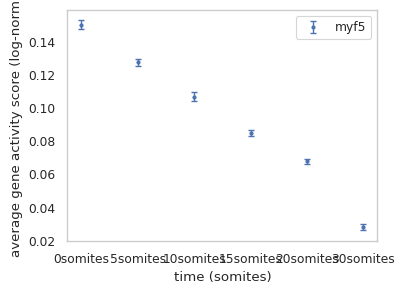

In [141]:
# Plotting the gene.activity dynamics (0-30 somites)
# define the gene
gene = "myf5"

# generate a plot
plt.figure(figsize=(4, 3))
plt.errorbar(timepoints_by_genes_sorted.index, 
             timepoints_by_genes_sorted[gene], 
             timepoints_by_genes_sem_sorted[gene],
             fmt='o', capsize=2, linestyle='None', 
             label=gene, markersize=2, elinewidth=1, capthick=1)
# plt.title('Scatter Plot of log-normalized counts over Timepoints')
plt.xlabel('time (somites)')
plt.ylabel('average gene activity score (log-norm)')
plt.xticks(timepoints_by_genes_sorted.index)  # Show original timepoint labels
plt.legend()
plt.grid(False)
# plt.savefig(figpath + "gene_activity_score_myf5.pdf")
plt.show()

In [ ]:
# Plotting the gene.activity dynamics (0-30 somites)
# define the gene
gene = "myf5"

# generate a plot
plt.figure(figsize=(4, 3))
plt.errorbar(timepoints_by_genes_sorted.index, 
             timepoints_by_genes_sorted[gene], 
             timepoints_by_genes_sem_sorted[gene],
             fmt='o', capsize=2, linestyle='None', 
             label=gene, markersize=2, elinewidth=1, capthick=1)
# plt.title('Scatter Plot of log-normalized counts over Timepoints')
plt.xlabel('time (somites)')
plt.ylabel('average gene activity score (log-norm)')
plt.xticks(timepoints_by_genes_sorted.index)  # Show original timepoint labels
plt.legend()
plt.grid(False)
# plt.savefig(figpath + "gene_activity_score_myf5.pdf")
plt.show()

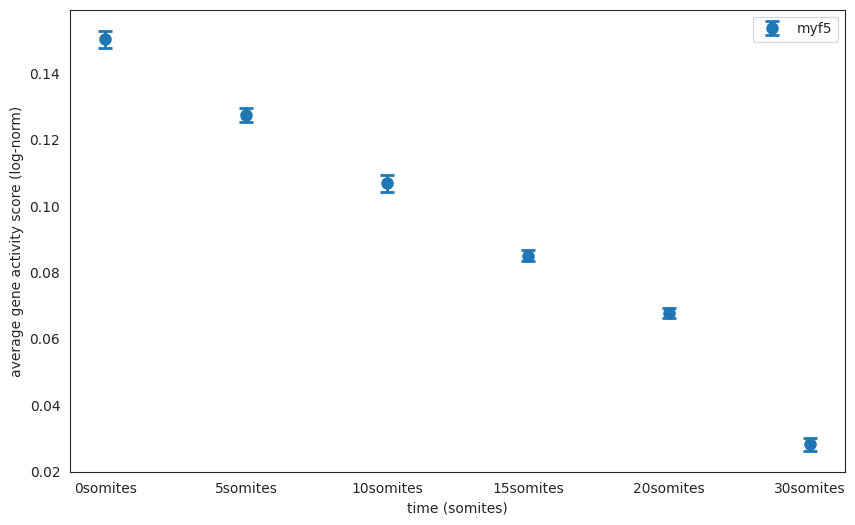

In [95]:
# Plotting the gene.activity dynamics (0-30 somites)
# define the gene
gene = "myf5"

# generate a plot
plt.figure(figsize=(4, 3))
plt.errorbar(timepoints_by_genes_sorted.index, 
             timepoints_by_genes_sorted[gene], 
             timepoints_by_genes_sem_sorted[gene],
             fmt='o', capsize=5, linestyle='None', 
             label=gene, markersize=8, elinewidth=2, capthick=2)
# plt.title('Scatter Plot of log-normalized counts over Timepoints')
plt.xlabel('time (somites)')
plt.ylabel('average gene activity score (log-norm)')
plt.xticks(timepoints_by_genes_sorted.index)  # Show original timepoint labels
plt.legend()
# plt.grid(True)
plt.savefig(figpath + "gene_activity_score_myf5.pdf")
plt.show()

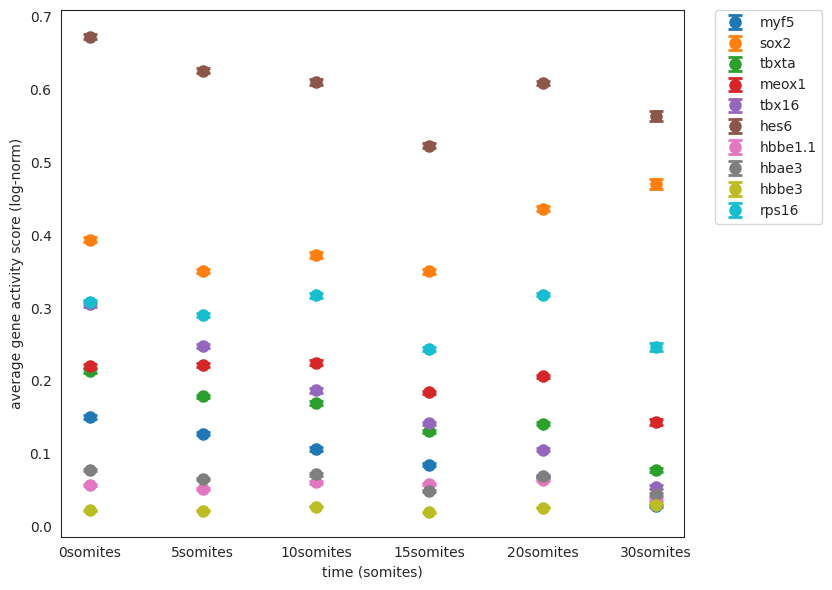

In [101]:
# Plotting the gene.activity dynamics (0-30 somites)
# define the gene
list_genes = ["myf5","sox2","tbxta",
              "meox1","tbx16","hes6",
              "hbbe1.1","hbae3","hbbe3","rps16"]

# generate a plot
plt.figure(figsize=(10, 6))

for gene in list_genes:
    plt.errorbar(timepoints_by_genes_sorted.index, 
                 timepoints_by_genes_sorted[gene], 
                 timepoints_by_genes_sem_sorted[gene],
                 fmt='o', capsize=5, linestyle='None', 
                 label=gene, markersize=8, elinewidth=2, capthick=2)
    
# plt.title('Scatter Plot of log-normalized counts over Timepoints')
plt.xlabel('time (somites)')
plt.ylabel('average gene activity score (log-norm)')
plt.xticks(timepoints_by_genes_sorted.index)  # Show original timepoint labels
# Move the legend outside of the plot to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect parameter to make room for the legend
plt.savefig(figpath + "gene_activity_score_genesets.pdf")
plt.show()

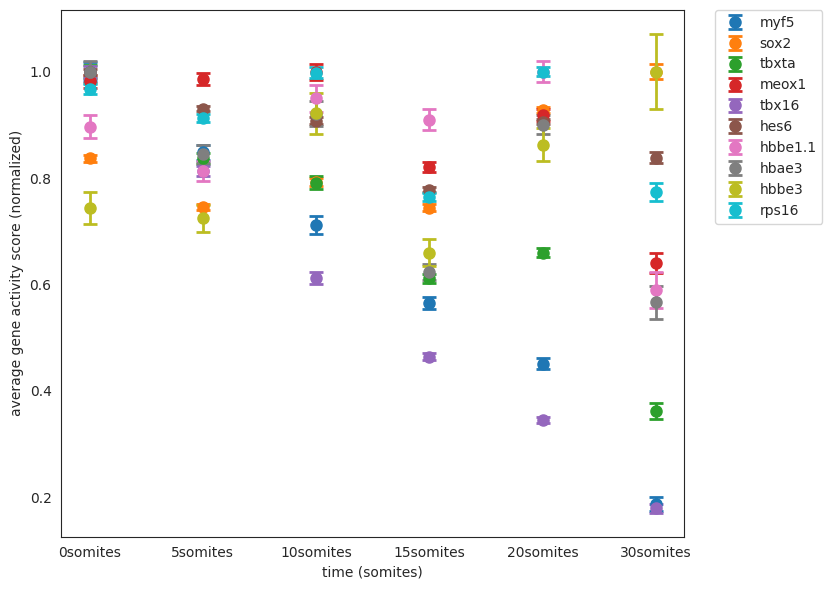

In [102]:
# Plotting the gene.activity dynamics (0-30 somites)
# define the gene
list_genes = ["myf5","sox2","tbxta",
              "meox1","tbx16","hes6",
              "hbbe1.1","hbae3","hbbe3","rps16"]

# generate a plot
plt.figure(figsize=(10, 6))

for gene in list_genes:
    # Normalization step: divide by the max value to scale to 1
    normalized_values = timepoints_by_genes_sorted[gene] / timepoints_by_genes_sorted[gene].max()
    plt.errorbar(timepoints_by_genes_sorted.index, 
                 normalized_values, 
                 yerr=timepoints_by_genes_sem_sorted[gene] / timepoints_by_genes_sorted[gene].max(), 
                 fmt='o', capsize=5, linestyle='None', 
                 label=gene, markersize=8, elinewidth=2, capthick=2)
    
# plt.title('Scatter Plot of log-normalized counts over Timepoints')
plt.xlabel('time (somites)')
plt.ylabel('average gene activity score (normalized)')
plt.xticks(timepoints_by_genes_sorted.index)  # Show original timepoint labels
# Move the legend outside of the plot to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect parameter to make room for the legend
plt.savefig(figpath + "gene_activity_score_genesets_normalized.pdf")
plt.show()

## Step . Find patterns in the ATAC dynamics

- First, we will normalize the timepoints_by_genes dataframe for each gene's maximum gene.activity score (averaged)
- Second, we will generate a heatmap for genes-by-timepoints
- Lastly, we will perform hirarchical clustering on the heatmap to find the gene clusters that have similar ATAC dynamics (either increasing or decreasing over time).

In [98]:
# first, exclude the "numeric_timepoints" column before normalization
timepoints_by_genes_sorted.drop('numeric_timepoints', axis=1, inplace=True)

# Normalize each gene's expression levels to the maximum value for that gene
normalized_timepoints_by_genes = timepoints_by_genes_sorted.divide(timepoints_by_genes_sorted.max())
normalized_timepoints_by_genes.head()

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-co2,mt-atp8,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb
timepoints,,,,,,,,,,,,,,,,,,,,,
0somites,0.925299,1.000000,1.000000,1.000000,1.000000,0.978833,0.996614,1.000000,1.000000,1.000000,...,0.797623,0.789397,0.797632,0.799873,0.792083,0.791100,0.809720,0.818155,0.786721,0.812451
5somites,0.971938,0.908025,0.902015,0.963170,0.921151,1.000000,1.000000,0.865590,0.803913,0.593862,...,0.907791,0.905362,0.908750,0.908745,0.902663,0.902585,0.913697,0.922762,0.911524,0.922297
10somites,1.000000,0.835346,0.824294,0.842048,0.855967,0.825859,0.920787,0.791133,0.762057,0.507760,...,0.787032,0.777368,0.785998,0.787762,0.777611,0.777604,0.797965,0.807474,0.773057,0.799399
15somites,0.794314,0.747085,0.779239,0.733673,0.720805,0.829988,0.763962,0.646208,0.604143,0.233134,...,0.779796,0.767294,0.780020,0.783846,0.778495,0.776929,0.793618,0.794752,0.750797,0.783483
20somites,0.852545,0.921242,0.966473,0.807666,0.896432,0.834767,0.911061,0.794453,0.810207,0.519330,...,0.835100,0.830015,0.836330,0.836516,0.827984,0.825594,0.838696,0.842373,0.816236,0.835613


In [116]:
# Replace any infinite values with NaN
timepoints_by_genes_sorted.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop any rows or columns with NaN values if they can't be imputed
# normalized_timepoints_by_genes.dropna(axis=0, inplace=True)  # Drop rows with NaN
timepoints_by_genes_sorted.dropna(axis=1, inplace=True)  # Drop columns with NaN

In [104]:
# Replace any infinite values with NaN
normalized_timepoints_by_genes.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop any rows or columns with NaN values if they can't be imputed
# normalized_timepoints_by_genes.dropna(axis=0, inplace=True)  # Drop rows with NaN
normalized_timepoints_by_genes.dropna(axis=1, inplace=True)  # Drop columns with NaN

In [107]:
normalized_timepoints_by_genes.T.head()

timepoints,0somites,5somites,10somites,15somites,20somites,30somites
ptpn12,0.925299,0.971938,1.000000,0.794314,0.852545,0.612921
phtf2,1.000000,0.908025,0.835346,0.747085,0.921242,0.581688
phtf2.1,1.000000,0.902015,0.824294,0.779239,0.966473,0.660974
CU856344.1,1.000000,0.963170,0.842048,0.733673,0.807666,0.563938
si:zfos-932h1.3,1.000000,0.921151,0.855967,0.720805,0.896432,0.831884


<Figure size 1200x800 with 0 Axes>

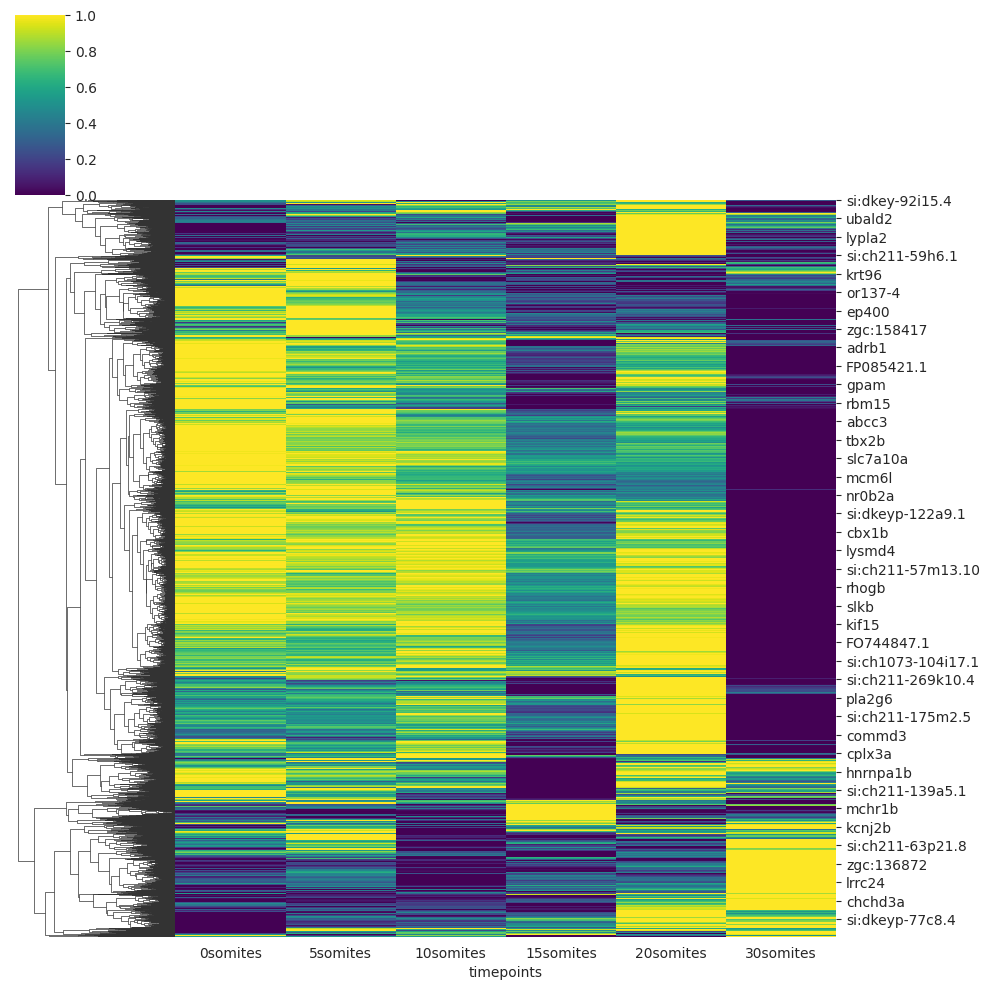

In [113]:
# Create a heatmap with hierarchical clustering
plt.figure(figsize=(12, 8))
sns.clustermap(normalized_timepoints_by_genes.T, method='average', metric='euclidean', cmap='viridis', standard_scale=0,
               row_cluster=True, col_cluster=False)
plt.show()

<Figure size 1200x800 with 0 Axes>

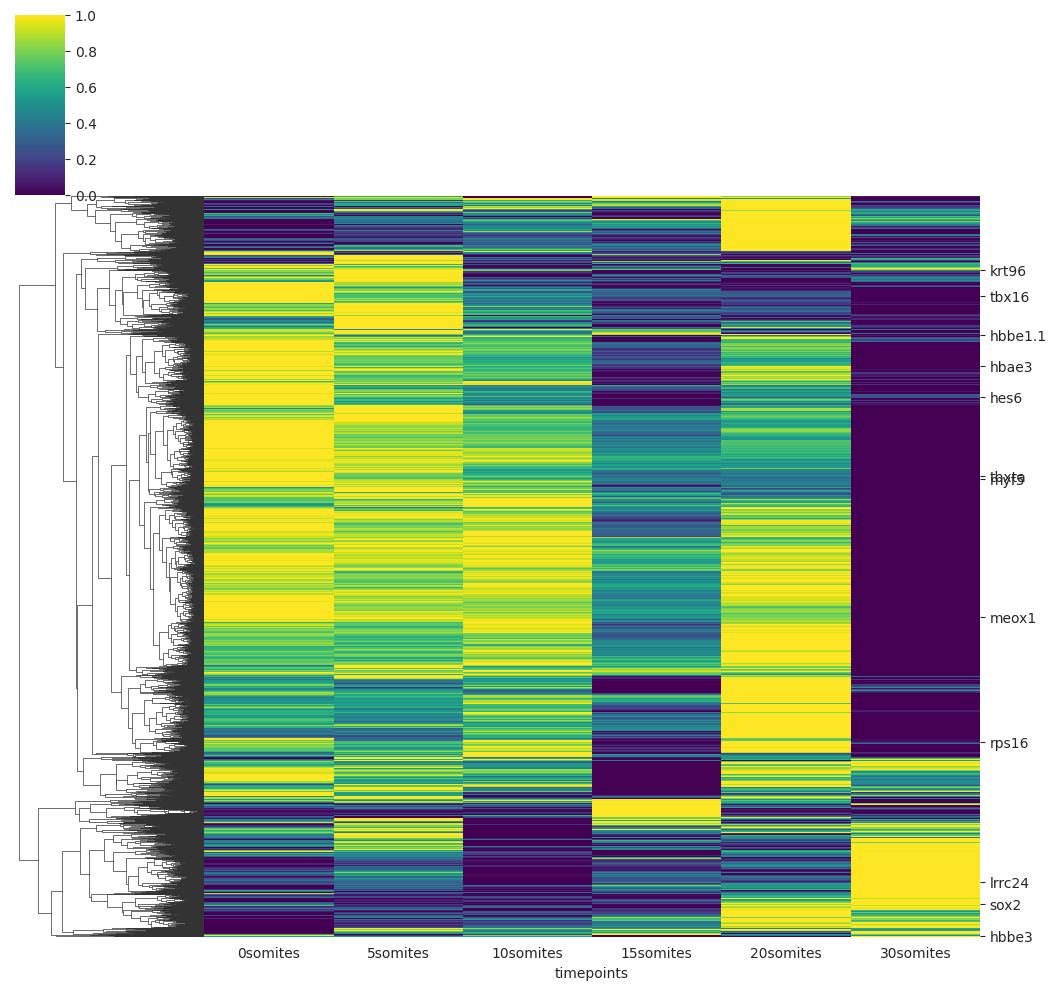

In [122]:
# Create a heatmap with hierarchical clustering
plt.figure(figsize=(12, 8))
g = sns.clustermap(normalized_timepoints_by_genes.T, method='average', metric='euclidean', cmap='viridis', standard_scale=0,
               row_cluster=True, col_cluster=False, yticklabels=False)

reordered_labels = normalized_timepoints_by_genes.T.index[g.dendrogram_row.reordered_ind].tolist()
use_labels = ["myf5","sox2","tbxta",
              "meox1","tbx16","hes6",
              "hbbe1.1","hbae3","hbbe3","rps16",
              "lrrc24","krt96"]
use_ticks = [reordered_labels.index(label) + .5 for label in use_labels]
g.ax_heatmap.set(yticks=use_ticks, yticklabels=use_labels)
g.savefig(figpath + "clustered_heatmap_gene_activity_score_timepoints_norm.png")
g.savefig(figpath + "clustered_heatmap_gene_activity_score_timepoints_norm.pdf")
plt.show()

## Step 4. GEX/Gene.activity dynamics along the pseudotime

- We will compute the pseudotime using RNA modality, and project the ATAC data along the pseudotime axis. The goals are the following
    - to see the temporal ordering between ATAC and RNA (how much delay is present, etc.)
    - monitor the dynamics of key TFs (both ATAC and RNA)

In [38]:
adata_RNA.obs["global_annotation"].unique()

array(['Epidermal', 'Lateral_Mesoderm', 'PSM', 'Neural_Posterior',
       'Neural_Anterior', 'Neural_Crest', 'Differentiating_Neurons',
       'Adaxial_Cells', 'Muscle', 'Somites', 'Endoderm', 'Notochord',
       'NMPs', 'unassigned'], dtype=object)

In [39]:
# First, let's subset the dataset for neuroecto_mesoderm objects
celltypes_to_include = ["Neural_Crest","Neural_Anterior","Neural_Posterior","NMPs","PSM","Somites","Muscle"]
NMP_traj = adata_RNA[adata_RNA.obs.global_annotation.isin(celltypes_to_include)]
NMP_traj

View of AnnData object with n_obs × n_vars = 59995 × 32057
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity', 'prediction.score.Germl

In [47]:
# preprocess the NMP_traj
NMP_traj.layers["counts"] = NMP_traj.X.copy()

# log-normalize and scale the counts
sc.pp.normalize_total(NMP_traj, target_sum=1e4)
sc.pp.log1p(NMP_traj)
sc.pp.scale(NMP_traj)

# compute PCA and neighbors
sc.tl.pca(NMP_traj, svd_solver="arpack")
sc.pp.neighbors(NMP_traj)

# compute diffmap
sc.tl.diffmap(NMP_traj)
# Calculate neihbors again based on diffusionmap
sc.pp.neighbors(NMP_traj, n_neighbors=10, use_rep='X_diffmap')


### Force-directed graph using PAGA

In [48]:
# PAGA graph construction
sc.tl.paga(NMP_traj, groups="global_annotation")

... storing 'orig.ident' as categorical
... storing 'global_annotation' as categorical


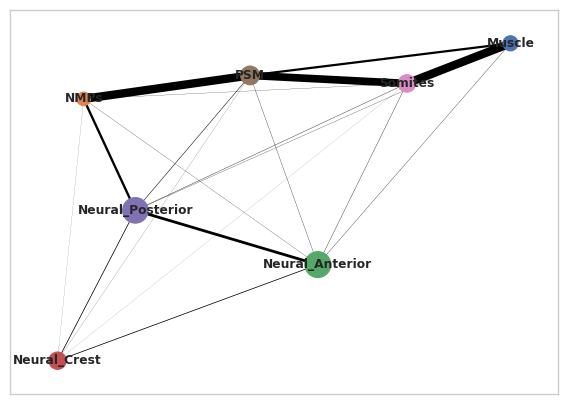

In [50]:
sc.pl.paga(NMP_traj)

In [51]:
sc.tl.draw_graph(NMP_traj, init_pos="paga", random_state=123)

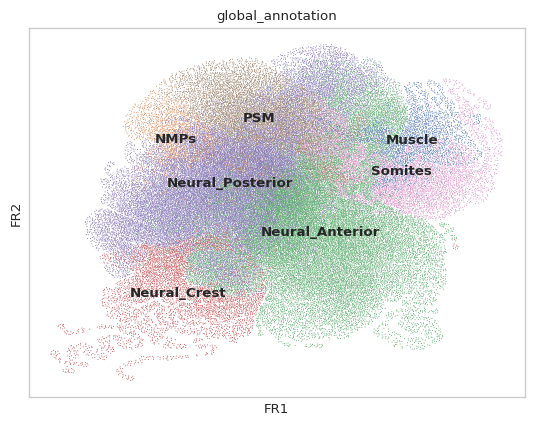

In [52]:
sc.pl.draw_graph(NMP_traj, color="global_annotation", legend_loc="on data")

### compute the Diffusion Pseudotime (DPT)

- we need to select the initial cell in DPT (https://www.sc-best-practices.org/trajectories/pseudotemporal.html)
The differentiation hierarchy in bone marrow is well understood. However, it is only known that the developmental process starts in the form of hematopoietic stem cells but not at which cell exactly in the corresponding cluster in our dataset. To identify a putative initial cell, we study the individual diffusion components. We identify the stem cell with the most extreme diffusion component in one dimension (in our case dimension 3).

In [54]:
NMP_traj[NMP_traj.obs.global_annotation=="NMPs"]

View of AnnData object with n_obs × n_vars = 1583 × 32057
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity', 'prediction.score.Germli

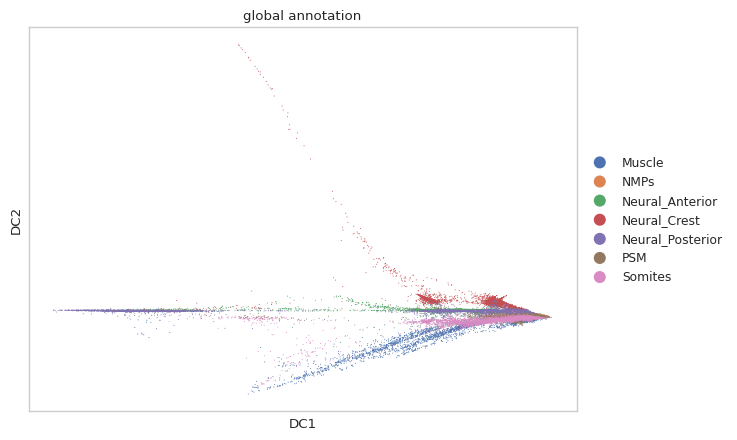

In [76]:
# Setting root cell as described above
# root_ixs = NMP_traj.obsm["X_diffmap"][:, 3].argmax()
sc.pl.scatter(
    NMP_traj,
    basis="diffmap",
    color=["global_annotation"],
    components=[1,2],
)


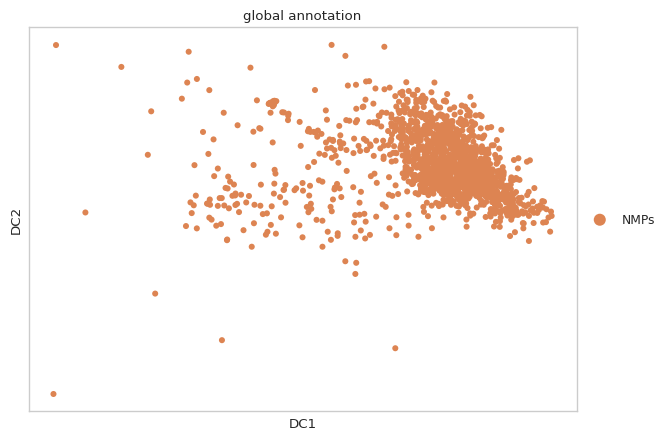

In [77]:
sc.pl.scatter(
    NMP_traj[NMP_traj.obs.global_annotation=="NMPs"],
    basis="diffmap",
    color=["global_annotation"],
    components=[1,2],
)

In [79]:
root_ixs

603

In [81]:
root_ixs = NMP_traj[NMP_traj.obs.global_annotation=="NMPs"].obsm["X_diffmap"][:, 1].argmax()
NMP_traj[NMP_traj.obs.global_annotation=="NMPs"].obs_names[root_ixs]

'CTAGTCGAGGATCCGC-1_5'

In [91]:
NMP_traj.obsm["X_diffmap"][:, 1].argmax()

38734

In [93]:
cell_index = NMP_traj.obs_names.get_loc('CTAGTCGAGGATCCGC-1_5')
cell_index

root_ixs = cell_index

In [95]:
NMP_traj.uns["iroot"] = root_ixs

In [97]:
NMP_traj

AnnData object with n_obs × n_vars = 59995 × 32057
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity', 'prediction.score.Germline', 'i

In [96]:
sc.tl.dpt(NMP_traj)

In [ ]:
sc

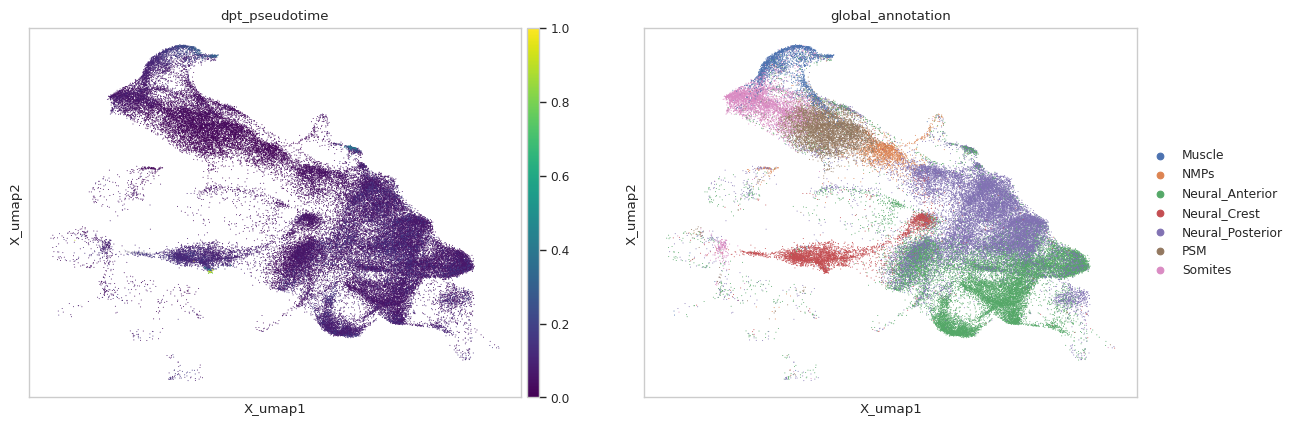

In [100]:
sc.pl.embedding(
    NMP_traj,
    basis="X_umap",
    color=["dpt_pseudotime", "global_annotation"],
    color_map="viridis",
)

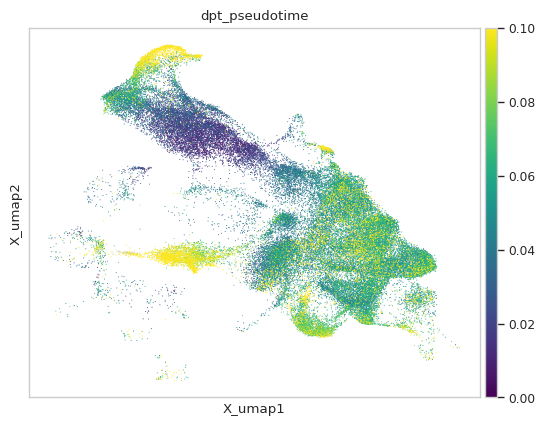

In [112]:
sc.pl.embedding(
    NMP_traj,
    basis="X_umap",
    color=["dpt_pseudotime"],
    color_map="viridis", vmin=0, vmax=0.1)

In [114]:
del NMP_traj.raw

In [115]:
NMP_traj.write_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/nmp_trajectories_subset_dpt.h5ad")

### Check the Gene.Activity (and GEX) dynamics along the pseudotime axis



In [124]:
# subset for the NMP trajectories (gene.activity)
NMP_gene_activity = adata_gene_activity[adata_gene_activity.obs_names.isin(NMP_traj.obs_names)]
NMP_gene_activity

View of AnnData object with n_obs × n_vars = 59995 × 25032
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity', 'nCount_peaks_integrate

In [125]:
NMP_gene_activity.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,nCount_SCT,...,nCount_Gene.Activity,nFeature_Gene.Activity,nCount_peaks_integrated,nFeature_peaks_integrated,dataset,prediction.score.Germline,integrated.weight,peaks_integrated.weight,wsnn_res.0.8,seurat_clusters
AAACAGCCATAGACCC-1_1,SeuratProject,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,26083.0,10345,32040.0,23386,TDR118,NaN,5.938950e-08,1.000000,6,14
AAACATGCAAACTCAT-1_1,SeuratProject,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,11748.0,6534,13090.0,11254,TDR118,NaN,3.694048e-01,0.630595,0,0
AAACATGCAAGGACCA-1_1,SeuratProject,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,3061.0,2376,3390.0,3149,TDR118,NaN,3.265597e-02,0.967344,23,3
AAACATGCAAGGATTA-1_1,SeuratProject,4233.0,1703,24072.0,10949,0.642451,0.72,4.636479,0.62,4729.0,...,13152.0,7376,15383.0,13086,TDR118,NaN,5.023156e-01,0.497684,34,4
AAACATGCACGTTACA-1_1,SeuratProject,4490.0,2026,25566.0,12021,0.732768,0.96,3.919890,0.09,4770.0,...,16819.0,8542,18447.0,15949,TDR118,NaN,3.385477e-01,0.661452,11,19


In [128]:
NMP_gene_activity.obs["dpt_pseudotime"] = NMP_traj.obs["dpt_pseudotime"]

In [126]:
NMP_traj.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,nCount_SCT,...,nCount_peaks_merged,nFeature_peaks_merged,SCT.weight,peaks_merged.weight,nCount_Gene.Activity,nFeature_Gene.Activity,prediction.score.Germline,integrated_snn_res.0.5,seurat_clusters,dpt_pseudotime
AAACAGCCATAGACCC-1_1,SeuratProject,12581.0,3467,51485.0,19874,0.514213,0.24,5.238692,0.92,5781.0,...,29548.0,21333,0.572315,0.427685,26083.0,10345,NaN,12,2,0.024950
AAACATGCAAACTCAT-1_1,SeuratProject,5642.0,2145,19812.0,9183,0.673319,0.85,4.409525,0.41,5363.0,...,11621.0,9939,0.481765,0.518235,11748.0,6534,NaN,1,1,0.045080
AAACATGCAAGGACCA-1_1,SeuratProject,2691.0,838,5182.0,2565,0.394904,0.06,4.939061,0.83,4727.0,...,2983.0,2761,0.408465,0.591535,3061.0,2376,NaN,15,3,0.045162
AAACATGCAAGGATTA-1_1,SeuratProject,4233.0,1703,24072.0,10949,0.642451,0.72,4.636479,0.62,4729.0,...,13992.0,11828,0.607841,0.392159,13152.0,7376,NaN,17,5,0.056854
AAACATGCACGTTACA-1_1,SeuratProject,4490.0,2026,25566.0,12021,0.732768,0.96,3.919890,0.09,4770.0,...,15879.0,13663,0.372726,0.627274,16819.0,8542,NaN,20,8,0.100230


In [133]:
# plot the ATAC dynamics along the pseudotime
NMP_traj.obs.global_annotation.unique()

mesoderm_traj = NMP_traj[NMP_traj.obs.global_annotation.isin(['PSM', 'Muscle', 'Somites', 'NMPs'])]
mesoderm_traj

View of AnnData object with n_obs × n_vars = 14273 × 32057
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity', 'prediction.score.Germl

In [142]:
mesoderm_traj_pdt

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ATAC,nFeature_ATAC,nucleosome_signal,nucleosome_percentile,TSS.enrichment,TSS.percentile,nCount_SCT,...,nCount_peaks_merged,nFeature_peaks_merged,SCT.weight,peaks_merged.weight,nCount_Gene.Activity,nFeature_Gene.Activity,prediction.score.Germline,integrated_snn_res.0.5,seurat_clusters,dpt_pseudotime
CTAGTCGAGGATCCGC-1_5,SeuratProject,2377.0,1153,22506.0,10473,0.826432,0.52,5.409780,0.97,2605.0,...,12973.0,11136,0.413404,0.586596,11942.0,7177,0.0,12,2,0.000000
GTGGCTTCATCAATCG-1_5,SeuratProject,3039.0,1372,45706.0,18726,0.867694,0.68,4.889040,0.79,2956.0,...,26572.0,19731,0.433878,0.566122,25561.0,10688,0.0,12,2,0.000565
GTGCTTACAATCGCAC-1_5,SeuratProject,3740.0,1818,18305.0,8589,0.781622,0.34,4.833905,0.75,3267.0,...,10553.0,9102,0.708833,0.291167,9976.0,6187,0.0,12,2,0.000834
TCTACCTCAAGCTTTG-1_5,SeuratProject,2539.0,1259,39484.0,16937,0.845949,0.60,4.330327,0.21,2680.0,...,23115.0,17948,0.432921,0.567079,22569.0,10301,0.0,12,2,0.000964
GTCTTGCTCATGCTAA-1_5,SeuratProject,2490.0,1164,47642.0,19521,0.843644,0.59,4.713805,0.63,2668.0,...,27931.0,20663,0.450989,0.549011,27621.0,11303,0.0,12,2,0.001038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTGGATCATTAGGCC-1_4,SeuratProject,6615.0,1836,38608.0,17499,0.776238,0.53,3.920373,0.07,4845.0,...,24046.0,19820,0.498652,0.501348,23409.0,10467,NaN,5,13,0.328473
GTACGTAGTAAAGCAA-1_7,SeuratProject,3563.0,1493,9374.0,4667,0.759887,0.15,4.384706,0.65,3428.0,...,5675.0,5141,0.504626,0.495374,5599.0,3903,NaN,5,13,0.329993
TCAGCGATCAATGACC-1_7,SeuratProject,3476.0,1544,36582.0,16572,0.855676,0.25,3.619727,0.03,3393.0,...,22267.0,18132,0.502288,0.497712,22402.0,9755,NaN,5,13,0.330884
CGAACCGGTTGACTTC-1_4,SeuratProject,7206.0,2126,16984.0,8453,0.825424,0.75,4.149085,0.24,4962.0,...,10486.0,9523,0.554422,0.445578,9729.0,6018,NaN,5,13,0.335453


In [143]:
# sort the indices using the dpt_pseudotime
mesoderm_traj.obs.sort_values("dpt_pseudotime", inplace=True)

# extract the count matrices
counts = pd.DataFrame(data=mesoderm_traj.X, 
                      index=mesoderm_traj.obs_names, 
                      columns=mesoderm_traj.var_names)
counts


,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-nd4,NC-002333.16,NC-002333.15,NC-002333.8,mt-nd5,mt-nd6,NC-002333.21,mt-cyb,NC-002333.22,NC-002333.11
CTAGTCGAGGATCCGC-1_5,-0.060348,-0.060131,-0.087956,-0.023776,7.510487,-0.015507,-0.111913,-0.155573,-0.134564,-0.131448,...,1.063001,-0.202856,-0.164858,-0.024763,0.034065,1.484261,-0.033733,0.419681,-0.039041,-0.038251
GTGGCTTCATCAATCG-1_5,-0.060348,-0.060131,-0.087956,-0.023776,-0.068265,-0.015507,-0.111913,-0.155573,-0.134564,-0.131448,...,0.543469,-0.202856,-0.164858,-0.024763,0.167710,0.330717,-0.033733,0.711001,-0.039041,-0.038251
GTGCTTACAATCGCAC-1_5,-0.060348,-0.060131,-0.087956,-0.023776,-0.068265,-0.015507,-0.111913,-0.155573,-0.134564,-0.131448,...,0.883414,-0.202856,-0.164858,-0.024763,0.665833,0.781587,-0.033733,0.265367,-0.039041,-0.038251
TCTACCTCAAGCTTTG-1_5,-0.060348,-0.060131,-0.087956,-0.023776,-0.068265,-0.015507,-0.111913,-0.155573,-0.134564,-0.131448,...,1.259326,-0.202856,-0.164858,-0.024763,0.598141,1.432667,-0.033733,0.907614,-0.039041,-0.038251
GTCTTGCTCATGCTAA-1_5,-0.060348,-0.060131,-0.087956,-0.023776,-0.068265,-0.015507,-0.111913,-0.155573,-0.134564,-0.131448,...,0.493101,-0.202856,-0.164858,-0.024763,-0.257394,1.053259,-0.033733,0.625914,-0.039041,-0.038251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTGGATCATTAGGCC-1_4,-0.060348,-0.060131,-0.087956,-0.023776,-0.068265,-0.015507,-0.111913,-0.155573,-0.134564,-0.131448,...,-0.851423,-0.202856,-0.164858,-0.024763,-1.349369,-0.561526,-0.033733,-1.173387,-0.039041,-0.038251
GTACGTAGTAAAGCAA-1_7,-0.060348,-0.060131,-0.087956,-0.023776,-0.068265,-0.015507,-0.111913,-0.155573,-0.134564,-0.131448,...,0.336096,-0.202856,-0.164858,-0.024763,1.742562,-0.561526,-0.033733,1.016811,-0.039041,-0.038251
TCAGCGATCAATGACC-1_7,-0.060348,-0.060131,-0.087956,-0.023776,-0.068265,-0.015507,-0.111913,-0.155573,-0.134564,-0.131448,...,-0.463166,-0.202856,-0.164858,-0.024763,0.836978,0.953611,-0.033733,-0.455996,-0.039041,-0.038251
CGAACCGGTTGACTTC-1_4,-0.060348,-0.060131,-0.087956,-0.023776,-0.068265,-0.015507,-0.111913,-0.155573,-0.134564,-0.131448,...,-0.127493,-0.202856,-0.164858,-0.024763,0.936253,-0.561526,-0.033733,0.130427,-0.039041,-0.038251


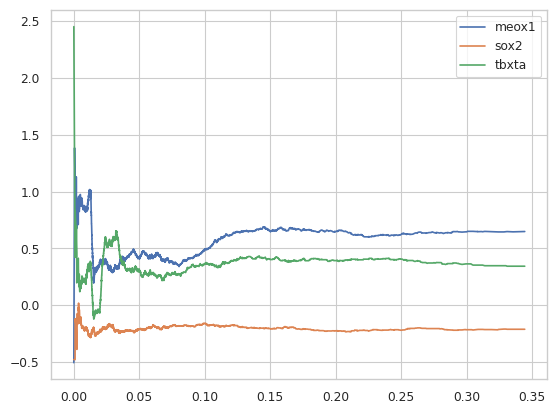

In [151]:
# pick some genes of interest
genes = ["meox1", "sox2","tbxta"]

# define the averaging window
window = 1000

for gene in genes:
    gene_counts = counts.loc[:, gene]
    
    # compute rolling window average
    roll_averaged = gene_counts.rolling(window=window, min_periods = 1).mean()
    
    
    #plt.scatter(mesoderm_traj.obs.dpt_pseudotime, counts.loc[:,gene])
    plt.plot(mesoderm_traj.obs.dpt_pseudotime, roll_averaged)
    
plt.legend(genes)
plt.show()


## computing pseudotime (Diffusion Pseudotime) for the integrated object using the nearest-neighbors computed using "integrated_pca" for integrated_RNA

In [ ]:
# basic preprocessing of the RNA modality (to compute the nearest-neighbors)


In [17]:
# import the "integrated_pca" computed from integrating all RNA(SCT) objects across datasets/timepoints - using rPCA
integrated_pca = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/integrated_pca.csv", index_col=0)
integrated_pca.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99,PC_100
AAACAGCCACCTAAGC-1_1,2.337219,-1.429061,-5.863204,2.233877,7.256290,2.174646,2.644288,-0.268576,1.116962,-1.540614,...,-2.423818,0.746383,2.348913,0.599667,0.268230,0.037639,1.093597,2.292499,-2.180902,-0.609504
AAACAGCCAGGGAGGA-1_1,5.925528,-4.112149,-3.745973,-2.587663,-0.824526,-0.770181,-0.629575,-2.431229,-0.577661,-2.289982,...,-0.596900,-0.580806,-0.151273,-2.579358,0.484555,4.244384,1.265782,1.041933,-0.790714,1.459041
AAACAGCCATAGACCC-1_1,3.573711,6.779139,-1.335192,-7.599583,3.383914,-2.221623,-0.410902,2.574602,2.494892,1.434072,...,-1.369190,-1.072793,0.729661,-2.383013,-2.462715,0.829521,-1.447832,-1.037105,-0.019790,-0.119438
AAACATGCAAACTCAT-1_1,-2.198315,-2.919139,4.460779,-3.449388,0.942443,2.305146,-0.609150,-0.384336,3.204518,-2.120470,...,-2.744978,0.271759,0.368134,0.654299,0.698463,3.075106,-1.206539,-0.504473,-1.483571,0.275104
AAACATGCAAGGACCA-1_1,-6.611312,4.038513,-0.699466,2.057417,-0.530705,-0.074898,0.746187,-0.692077,-0.832365,0.885615,...,-0.152070,0.280815,0.164693,0.946766,-0.844613,0.023811,0.588854,0.407269,0.394212,0.313771


In [31]:
# add the 'integrated_pca' to adata.obsm
adata_RNA.obsm["X_integrated_pca"] = integrated_pca.to_numpy()

In [33]:
# compute the nearest neighbors using the first 30 PCs
sc.pp.neighbors(adata_RNA, use_rep="X_integrated_pca", n_pcs=30)

In [104]:
# First, compute the pseudotime using RNA (DPT)
sc.tl.diffmap(adata_RNA)

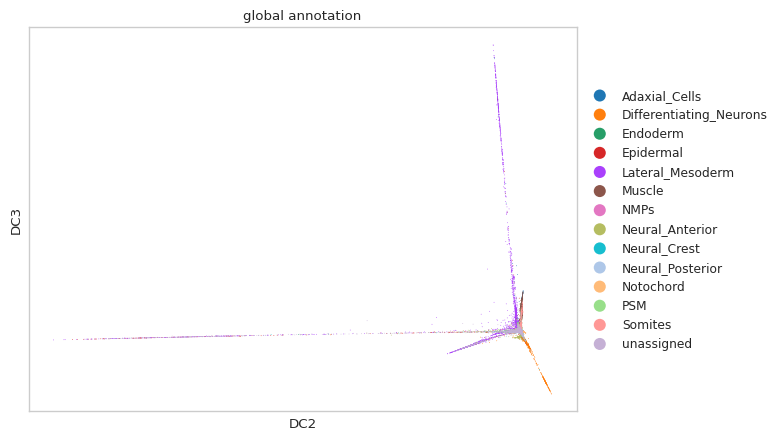

In [108]:
sc.pl.scatter(
    adata_RNA,
    basis="diffmap",
    color=["global_annotation"],
    components=[2, 3],
)

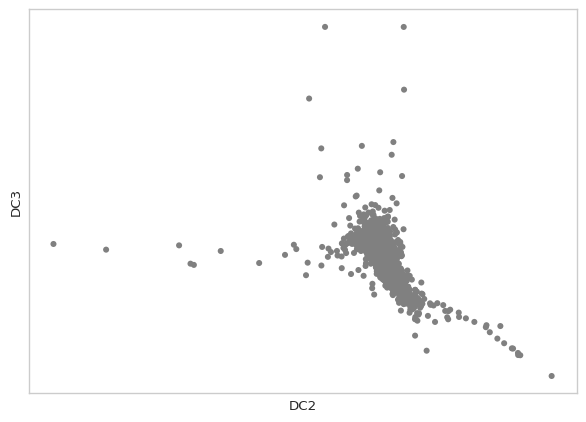

In [154]:
sc.pl.scatter(adata_RNA[adata_RNA.obs.global_annotation=="NMPs"],
               basis="diffmap",
               components=[2,3])

### computing DPT - start by selecting the "root" cells

In [157]:
# Get the indices of NMPs
nmp_indices = adata_RNA.obs[adata_RNA.obs.global_annotation == "NMPs"].index

# Get the diffusion map coordinates of NMPs
diffmap_coords = adata_RNA[nmp_indices].obsm["X_diffmap"][:, [1, 2]]  # assuming 2nd and 3rd components are in columns 1 and 2

# Calculate the centroid of the NMPs' diffusion map coordinates
centroid = np.mean(diffmap_coords, axis=0)

# Find the closest cell to the centroid
distances = np.sqrt(np.sum((diffmap_coords - centroid) ** 2, axis=1))
root_cell_index = np.argmin(distances)

# The index of the root cell in the original dataset
root_cell_id = nmp_indices[root_cell_index]
root_cell_id

'CTAACCACAATTAAGG-1_5'

In [159]:
cell_index = adata_RNA.obs_names.get_loc('CTAACCACAATTAAGG-1_5')
cell_index

root_ixs = cell_index
root_ixs

56127

In [160]:
adata_RNA.uns["iroot"] = root_ixs

In [161]:
# compute Pseudotime using DPT
sc.tl.dpt(adata_RNA)

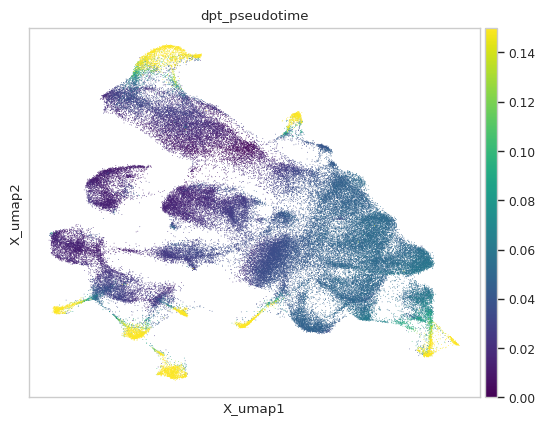

In [165]:
sc.pl.embedding(
    adata_RNA,
    basis="X_umap",
    color=["dpt_pseudotime"],
    color_map="viridis", vmin=0, vmax=0.15)

subset for the mesoderm fates

In [170]:
# subset for the NMP trajectories (gene.activity)
mesoderm_gene_activity = adata_gene_activity[adata_gene_activity.obs.global_annotation.isin(['PSM', 'Muscle', 'Somites', 'NMPs'])]
mesoderm_gene_activity

View of AnnData object with n_obs × n_vars = 14273 × 25032
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity', 'nCount_peaks_integrate

In [171]:
mesoderm_RNA = adata_RNA[adata_RNA.obs.global_annotation.isin(['PSM', 'Muscle', 'Somites', 'NMPs'])]
mesoderm_RNA

View of AnnData object with n_obs × n_vars = 14273 × 32057
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity', 'prediction.score.Germl

In [172]:
mesoderm_gene_activity.obs["dpt_pseudotime"] = mesoderm_RNA.obs["dpt_pseudotime"]

In [174]:
mesoderm_gene_activity.X

<14273x25032 sparse matrix of type '<class 'numpy.float64'>'
	with 119909407 stored elements in Compressed Sparse Row format>

In [175]:
# sort the indices using the dpt_pseudotime
mesoderm_gene_activity.obs.sort_values("dpt_pseudotime", inplace=True)

# extract the count matrices
counts = pd.DataFrame(data=mesoderm_gene_activity.X.todense(), 
                      index=mesoderm_gene_activity.obs_names, 
                      columns=mesoderm_gene_activity.var_names)
counts


,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-co2,mt-atp8,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb
CTAACCACAATTAAGG-1_5,0.000000,0.000000,0.000000,0.424521,0.000000,0.0,0.000000,0.424521,0.656218,0.000000,...,1.622419,1.589812,1.660038,1.632390,1.612023,1.589812,1.660038,1.651173,1.364937,1.565428
CTTTGGGAGTCATTGA-1_6,0.000000,0.000000,0.000000,0.000000,1.162234,0.0,1.162234,0.000000,0.000000,0.000000,...,2.338493,2.321971,2.371881,2.388401,2.362980,2.380342,2.417246,2.380342,2.110078,2.260759
ACCATTAAGTGAACGA-1_6,0.000000,0.000000,0.000000,0.646642,1.077669,0.0,0.646642,0.646642,0.000000,0.000000,...,1.863703,1.801483,1.811546,1.830377,1.755942,1.624142,1.830377,1.839210,1.576187,1.768221
AGAGATTAGTTATCTC-1_1,0.582389,0.000000,0.000000,0.000000,0.843883,0.0,0.000000,0.843883,0.582389,0.000000,...,1.732690,1.709289,1.773315,1.799553,1.732690,1.732690,1.850639,1.822961,1.511641,1.669110
GGCTCACAGTATGTGC-1_6,0.000000,0.000000,0.000000,0.000000,1.229069,0.0,0.000000,0.771879,0.398602,0.000000,...,1.599349,1.522600,1.547044,1.579744,1.579744,1.522600,1.678597,1.697880,1.370870,1.547044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGAACCGGTTGACTTC-1_4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.322175,0.948512,0.948512,...,1.867083,1.828405,1.907983,1.903830,1.907983,1.923768,1.973590,1.976489,1.773287,1.907983
CATTCATTCTTGCTAT-1_7,0.000000,0.586098,0.586098,0.000000,0.849145,0.0,0.586098,0.586098,0.000000,0.000000,...,1.953587,1.896786,1.945182,1.969377,1.945182,1.949430,2.027621,2.038407,1.861006,2.016159
ACTTAGTCATGAATAG-1_4,0.000000,1.152078,0.821769,0.495440,0.891240,0.0,0.000000,0.632732,0.303124,0.737731,...,1.502527,1.453231,1.536062,1.519856,1.430571,1.378569,1.483925,1.493395,1.314550,1.474091
TACAGCTAGGATGATG-1_4,0.000000,0.000000,0.000000,0.729702,0.000000,0.0,0.485311,1.085202,0.485311,0.000000,...,1.736650,1.686539,1.704501,1.721150,1.686539,1.695696,1.817074,1.854649,1.582681,1.744013


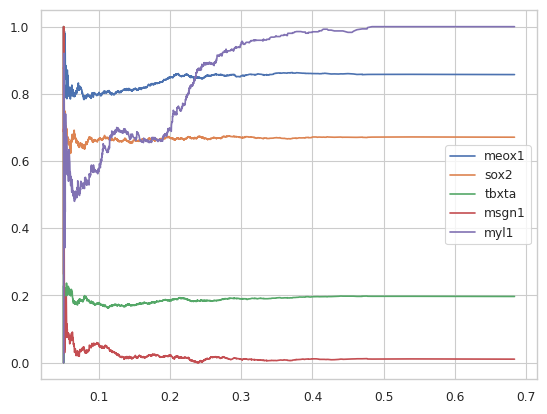

In [212]:
# pick some genes of interest
genes = ["meox1","sox2","tbxta","msgn1","myl1"]

# define the averaging window
window = 2000

# Apply the cut-off at 0.05 in pseudotime and normalize
pseudotime = mesoderm_gene_activity.obs['dpt_pseudotime']
cut_off_mask = pseudotime >= 0.05
normalized_pseudotime = pseudotime[cut_off_mask]

for gene in genes:
    gene_counts = counts.loc[:, gene]
    
    gene_counts = gene_counts[cut_off_mask]
    
    # compute rolling window average
    roll_averaged = gene_counts.rolling(window=window, min_periods = 1).mean()
    
    # Normalize the rolling average
    normalized_rolling_average = (roll_averaged - roll_averaged.min()) / (roll_averaged.max() - roll_averaged.min())
    
    #plt.scatter(mesoderm_traj.obs.dpt_pseudotime, counts.loc[:,gene])
    plt.plot(normalized_pseudotime, normalized_rolling_average)
    
plt.legend(genes)
plt.show()


In [194]:
# sort the indices using the dpt_pseudotime
mesoderm_RNA.obs.sort_values("dpt_pseudotime", inplace=True)

# extract the count matrices
counts_RNA = pd.DataFrame(data=mesoderm_RNA.X.todense(), 
                      index=mesoderm_RNA.obs_names, 
                      columns=mesoderm_RNA.var_names)
counts_RNA

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-nd4,NC-002333.16,NC-002333.15,NC-002333.8,mt-nd5,mt-nd6,NC-002333.21,mt-cyb,NC-002333.22,NC-002333.11
CTAACCACAATTAAGG-1_5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,3.0,3.0,0.0,62.0,0.0,0.0
CTTTGGGAGTCATTGA-1_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.0,0.0,0.0,0.0,4.0,1.0,0.0,82.0,0.0,0.0
ACCATTAAGTGAACGA-1_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,0.0,0.0,0.0,4.0,1.0,0.0,37.0,0.0,0.0
AGAGATTAGTTATCTC-1_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,0.0,0.0,0.0,2.0,1.0,0.0,28.0,0.0,0.0
GGCTCACAGTATGTGC-1_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,1.0,1.0,0.0,34.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGAACCGGTTGACTTC-1_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
CATTCATTCTTGCTAT-1_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,4.0,0.0,0.0,19.0,0.0,0.0
ACTTAGTCATGAATAG-1_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,4.0,1.0,0.0,21.0,0.0,0.0
TACAGCTAGGATGATG-1_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,2.0,0.0,0.0,13.0,0.0,0.0


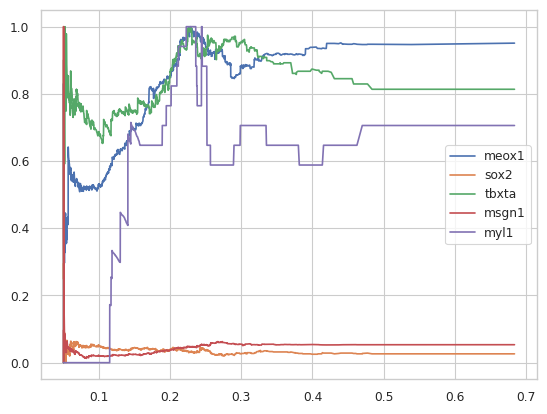

In [213]:
# pick some genes of interest
genes = ["meox1","sox2","tbxta","msgn1","myl1"]

# define the averaging window
window = 1000

# Apply the cut-off at 0.05 in pseudotime and normalize
pseudotime = mesoderm_RNA.obs['dpt_pseudotime']
cut_off_mask = pseudotime >= 0.05
normalized_pseudotime = pseudotime[cut_off_mask]

for gene in genes:
    gene_counts = counts_RNA.loc[:, gene]
    
    gene_counts = gene_counts[cut_off_mask]
    
    # compute rolling window average
    roll_averaged = gene_counts.rolling(window=window, min_periods = 1).mean()
    
    # Normalize the rolling average
    normalized_rolling_average = (roll_averaged - roll_averaged.min()) / (roll_averaged.max() - roll_averaged.min())
    
    #plt.scatter(mesoderm_traj.obs.dpt_pseudotime, counts.loc[:,gene])
    plt.plot(normalized_pseudotime, normalized_rolling_average)
    
plt.legend(genes)
plt.show()

In [199]:
normalized_pseudotime

CTAACCTGTTGCAGTA-1_1    0.050035
TACTTGTTCGCTAAAC-1_1    0.050055
GCGAAGTAGTCAGGCC-1_2    0.050083
CAGGCTATCTGGTCCT-1_5    0.050089
GATTCAGGTGTCCAGG-1_7    0.050130
                          ...   
CGAACCGGTTGACTTC-1_4    0.476768
CATTCATTCTTGCTAT-1_7    0.477403
ACTTAGTCATGAATAG-1_4    0.483732
TACAGCTAGGATGATG-1_4    0.538972
TAGTGGCGTAGGTTTG-1_4    0.684069
Name: dpt_pseudotime, Length: 2309, dtype: float32

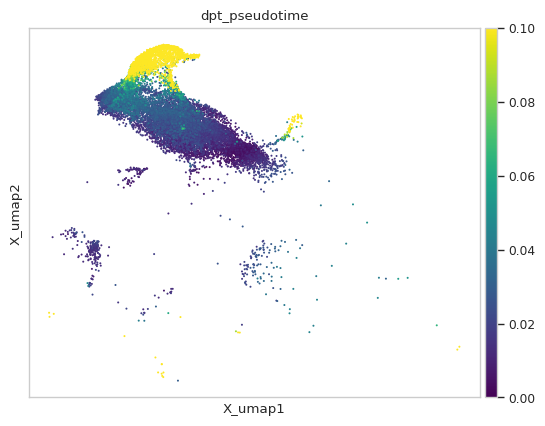

In [182]:
sc.pl.embedding(
    mesoderm_RNA,
    basis="X_umap",
    color=["dpt_pseudotime"],
    color_map="viridis", vmin=0, vmax=0.1)

In [80]:
list_genes_ML = ["lrrc17","comp","ripply1","rx1","vsx2","tbx16","myf5",
                   "hes6","crestin","ednrab","dlx2a","cldni","cfl1l",
                   "fezf1","sox1b","foxg1a","olig3","hoxd4a","rxrga",
                   "gata5","myh7","tnnt2a",'pkd1b',"scg3","etv5a","pitx3",
                   "elavl3","stmn1b","sncb","myog","myl1","jam2a",
                   "prrx1","nid1b","cpox","gata1a","hbbe1","unc45b","ttn1",
                   "apobec2a","foxi3b","atp1b1b","fli1b","kdrl","anxa4",
                   "cldnc","cldn15a","tbx3b","loxl5b","emilin3a","sema3aa","irx7","vegfaa",
                   "ppl","krt17","icn2","osr1","hand2","shha","shhb","foxa2",
                   "cebpa","spi1b","myb","ctslb","surf4l","sec61a1l","mcf2lb",
                   "bricd5","etnk1","chd17","acy3"]

In [41]:
# # Calculate the mean of the counts for TDR118reseq and TDR119reseq
# mean_TDR118_TDR119_reseq = dataset_by_genes.loc[['TDR118reseq', 'TDR119reseq']].mean(axis=0)

# # Add the mean as a new row in the dataset_by_genes DataFrame
# dataset_by_genes.loc['TDR118_TDR119_reseq_avg'] = mean_TDR118_TDR119_reseq

# # Optionally, if you want to remove the original TDR118reseq and TDR119reseq rows
# dataset_by_genes = dataset_by_genes.drop(['TDR118reseq', 'TDR119reseq'])

# dataset_by_genes

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-co2,mt-atp8,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb
dataset,,,,,,,,,,,,,,,,,,,,,
TDR124reseq,0.095111,0.138486,0.079551,0.182402,0.707647,0.054272,0.140589,0.310097,0.228772,0.108782,...,3.733301,3.518038,3.713410,3.770773,3.643798,3.608102,3.937865,3.965087,3.213551,3.758859
TDR125reseq,0.132296,0.219326,0.116319,0.261235,0.762555,0.068222,0.165915,0.425418,0.375774,0.368629,...,3.117679,2.920023,3.105637,3.154313,3.017005,2.978828,3.302670,3.340081,2.623016,3.140953
TDR126,0.143585,0.238076,0.120355,0.323444,0.850656,0.079996,0.181496,0.535486,0.463799,0.709817,...,2.977765,2.777127,2.961935,3.016140,2.886192,2.854369,3.188570,3.244055,2.528167,3.053888
TDR127,0.150823,0.216179,0.108562,0.311532,0.783582,0.081726,0.182112,0.463511,0.372854,0.421533,...,3.389056,3.185097,3.374560,3.426672,3.289121,3.256618,3.598017,3.658834,2.929228,3.466786
TDR128,0.155177,0.198876,0.099208,0.272355,0.728134,0.067494,0.167687,0.423641,0.353442,0.360416,...,2.938229,2.734809,2.918733,2.970474,2.833458,2.805676,3.142279,3.201706,2.484257,3.004827
TDR118_TDR119_reseq_avg,0.123091,0.177622,0.093710,0.237736,0.611768,0.067777,0.138830,0.345394,0.279991,0.162865,...,2.902097,2.690465,2.887464,2.946533,2.827205,2.793847,3.116277,3.143047,2.404790,2.936845


In [42]:
# Transpose dataset_by_genes so genes are rows and datasets are columns
genes_by_dataset = dataset_by_genes.T

# Define your specific order for datasets
specific_order = ["TDR126", "TDR127", "TDR128", "TDR118_TDR119_reseq_avg", "TDR125reseq", "TDR124reseq"]

# Reorder the columns of genes_by_dataset according to specific_order
genes_by_dataset = genes_by_dataset[specific_order]

In [45]:
genes_by_dataset

dataset,TDR126,TDR127,TDR128,TDR118_TDR119_reseq_avg,TDR125reseq,TDR124reseq
ptpn12,0.143585,0.150823,0.155177,0.123091,0.132296,0.095111
phtf2,0.238076,0.216179,0.198876,0.177622,0.219326,0.138486
phtf2.1,0.120355,0.108562,0.099208,0.093710,0.116319,0.079551
CU856344.1,0.323444,0.311532,0.272355,0.237736,0.261235,0.182402
si:zfos-932h1.3,0.850656,0.783582,0.728134,0.611768,0.762555,0.707647
...,...,...,...,...,...,...
mt-nd4l,2.854369,3.256618,2.805676,2.793847,2.978828,3.608102
mt-nd4,3.188570,3.598017,3.142279,3.116277,3.302670,3.937865
mt-nd5,3.244055,3.658834,3.201706,3.143047,3.340081,3.965087
mt-nd6,2.528167,2.929228,2.484257,2.404790,2.623016,3.213551


In [47]:
# subset the genes for the highly variables genes (3000, as the total number of genes is 25K)
list_hvg = list(set(genes_by_dataset.index).intersection(set(list_hvg_RNA)))
genes_subset = genes_by_dataset.loc[list_hvg]
genes_subset

dataset,TDR126,TDR127,TDR128,TDR118_TDR119_reseq_avg,TDR125reseq,TDR124reseq
tmem178b,0.433414,0.444739,0.451627,0.434350,0.474689,0.453822
otpa,0.334785,0.308871,0.327568,0.291885,0.366476,0.253841
gpc1b,0.346753,0.360829,0.342511,0.399387,0.409323,0.423613
spaca4l,0.124868,0.118970,0.118302,0.086829,0.088203,0.052245
agrn,1.906740,1.983162,1.999299,2.018016,2.077458,1.965909
...,...,...,...,...,...,...
en1a,0.200343,0.181286,0.203082,0.149854,0.217535,0.130401
thsd7ba,0.930655,0.956099,0.880792,0.891935,0.844254,0.938770
scube1,0.659383,0.619644,0.574271,0.547478,0.582828,0.511242
gpc5a,0.814849,0.828898,0.836544,0.829762,0.911017,0.900498


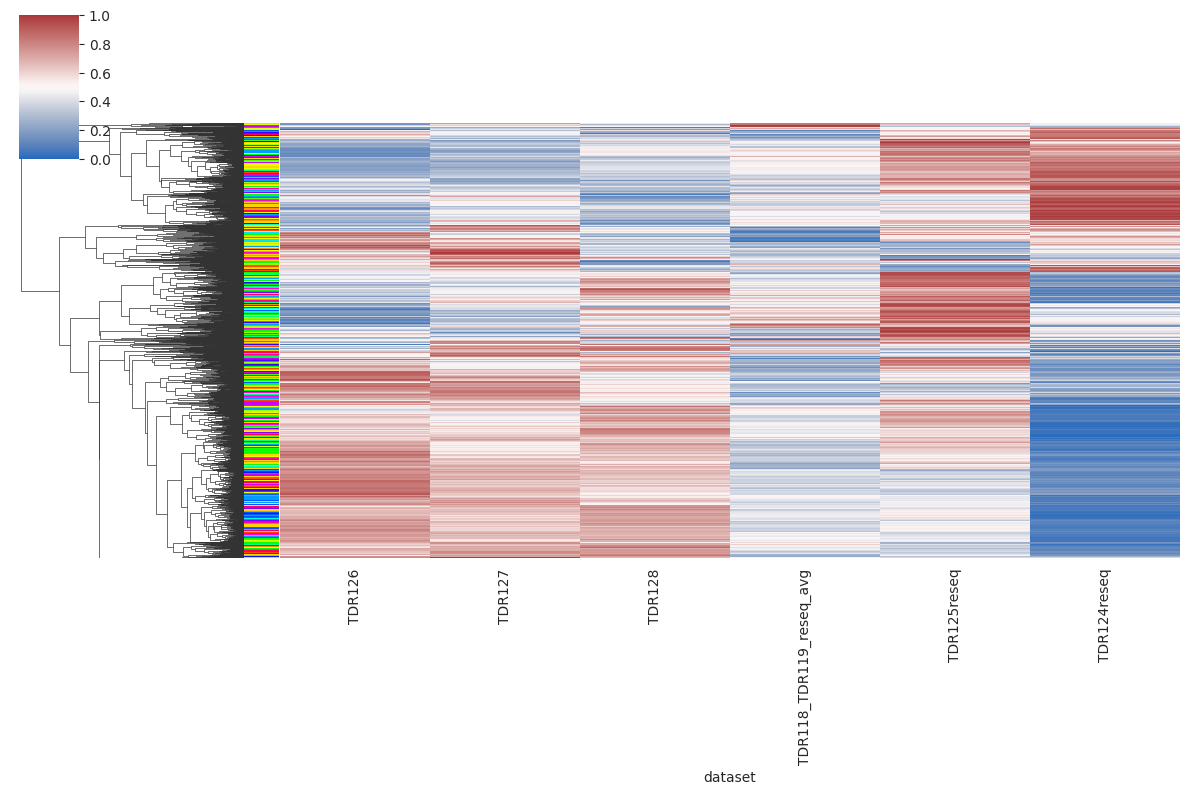

In [48]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster


# Step 1: Normalize the data (z-score for each gene)
genes_by_dataset_zscored = genes_subset.apply(zscore, axis=1)

# Step 2: Cluster the genes
# Check for non-finite values (NaN, Inf, -Inf) in the DataFrame
if not np.all(np.isfinite(genes_by_dataset_zscored)):
    # Replace non-finite values with zero or another suitable value
    genes_by_dataset_zscored = genes_by_dataset_zscored.replace([np.inf, -np.inf], np.nan)
    # You can fill NaN values with zero or some other imputation method
    genes_by_dataset_zscored = genes_by_dataset_zscored.fillna(0)

# Proceed with clustering now that the data contains only finite values
linkage_matrix = linkage(genes_by_dataset_zscored, method='ward')
gene_order = leaves_list(linkage_matrix)
genes_by_dataset_clustered = genes_by_dataset_zscored.iloc[gene_order]


# Step 3: Determine clusters for the side color bar
gene_clusters = fcluster(linkage_matrix, t=20, criterion='maxclust')
cluster_colors = sns.color_palette("hsv", np.unique(gene_clusters).max())
row_colors = pd.Series(gene_clusters, index=genes_by_dataset_clustered.index).map(dict(zip(np.unique(gene_clusters), cluster_colors)))

# Step 4: Generate the heatmap
sns.clustermap(genes_by_dataset_clustered,
               row_cluster=True, col_cluster=False,
               standard_scale=1, # Normalize across rows
               row_colors=row_colors, # Add cluster colors
               cmap="vlag", # Use a diverging color palette
               linewidths=0.0, # No lines between cells
               figsize=(12, 8), # Adjust the figure size to your data
               xticklabels=True, yticklabels=False) # Remove gene labels for clarity

plt.show()

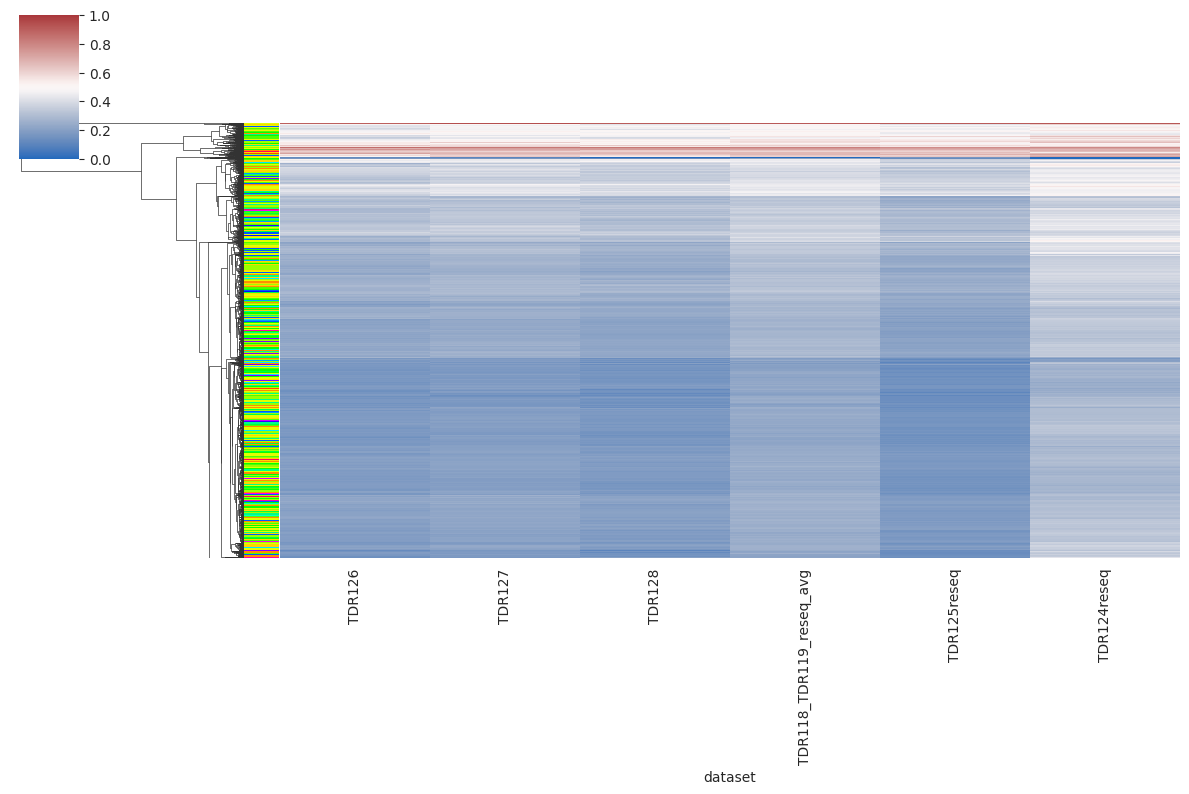

In [185]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster


# Step 1: Normalize the data (z-score for each gene)
genes_by_dataset_zscored = genes_subset

# Step 2: Cluster the genes
# Check for non-finite values (NaN, Inf, -Inf) in the DataFrame
if not np.all(np.isfinite(genes_by_dataset_zscored)):
    # Replace non-finite values with zero or another suitable value
    genes_by_dataset_zscored = genes_by_dataset_zscored.replace([np.inf, -np.inf], np.nan)
    # You can fill NaN values with zero or some other imputation method
    genes_by_dataset_zscored = genes_by_dataset_zscored.fillna(0)

# Proceed with clustering now that the data contains only finite values
linkage_matrix = linkage(genes_by_dataset_zscored, method='ward')
gene_order = leaves_list(linkage_matrix)
genes_by_dataset_clustered = genes_by_dataset_zscored.iloc[gene_order]


# Step 3: Determine clusters for the side color bar
gene_clusters = fcluster(linkage_matrix, t=20, criterion='maxclust')
cluster_colors = sns.color_palette("hsv", np.unique(gene_clusters).max())
row_colors = pd.Series(gene_clusters, index=genes_by_dataset_clustered.index).map(dict(zip(np.unique(gene_clusters), cluster_colors)))

# Step 4: Generate the heatmap
sns.clustermap(genes_by_dataset_clustered,
               row_cluster=True, col_cluster=False,
               standard_scale=1, # Normalize across rows
               row_colors=row_colors, # Add cluster colors
               cmap="vlag", # Use a diverging color palette
               linewidths=0.0, # No lines between cells
               figsize=(12, 8), # Adjust the figure size to your data
               xticklabels=True, yticklabels=False) # Remove gene labels for clarity

plt.show()

In [99]:
# # Assuming gene_clusters is an array-like object with the cluster labels for each gene
# # Create a DataFrame mapping genes to their clusters
# gene_cluster_map = pd.DataFrame({'cluster': gene_clusters}, index=genes_by_dataset_clustered.index)

# # Sort the genes by cluster label
# gene_cluster_map_sorted = gene_cluster_map.sort_values('cluster')

# # Reorder the gene expression data to match the sorted cluster labels
# genes_by_dataset_clustered_sorted = genes_by_dataset_zscored.loc[gene_cluster_map_sorted.index]

# # Generate the heatmap with rows ordered by cluster
# sns.clustermap(genes_by_dataset_clustered_sorted, 
#                row_cluster=False,  # Do not cluster rows, as they are pre-sorted
#                col_cluster=False,  # Assuming columns are already in the desired order
#                cmap="vlag", 
#                figsize=(12, 8), 
#                xticklabels=True, 
#                yticklabels=False)

# plt.show()

In [80]:
# Create a DataFrame that maps each gene to its cluster
gene_cluster_map = pd.DataFrame({
    'gene': genes_by_dataset_clustered.index,
    'cluster': gene_clusters
})

# Assuming gene_cluster_map is a DataFrame where 'gene' is a column and 'cluster' is a column
gene_cluster_map.set_index('gene', inplace=True)
gene_cluster_map

,cluster
gene,
ca10b,12
neto1l,8
galn,16
mmp13a,3
p2rx3a,15
...,...
hbbe1.3,8
dlc,20
trpc4a,4


In [92]:
gene_cluster_map[gene_cluster_map.cluster==20].index.to_list()

['scg3',
 'loxl5b',
 'htr1fa',
 'gria4b',
 'dpp4',
 'krt99',
 'prex2',
 'sostdc1b',
 'rasa4',
 'camkk1a',
 'tmsb1',
 'arhgap27l',
 'rcvrn2',
 'zgc:171775',
 'hsd11b2',
 'rdh5',
 'tdrd7a',
 'net1',
 'rgs6',
 'nhlh2',
 'prom2',
 'dlx5a',
 'hoxc6b',
 'bmper',
 'has2',
 'dlx4b',
 'tmem72',
 'mmp15b',
 'afap1',
 'fgf8a',
 'slc2a15a',
 'btbd11b',
 'lft1',
 'samd7',
 'apoa2',
 'myf5',
 'EML5',
 'scube1',
 'tfec',
 'si:dkey-218h11.6',
 'plxna2',
 'slco3a1',
 'npnta',
 'ogfrl1',
 'exoc3l4',
 'slc9a3r1a',
 'quo',
 'ablim1b',
 'olig2',
 'bsx',
 'hsp90ab1',
 'zgc:64106',
 'fhdc2',
 'si:dkey-1c11.1',
 'fkbp11',
 'evx2',
 'urod',
 'tfap2b',
 'tmem38a',
 'sptb',
 'tulp1b',
 'si:dkey-172h23.2',
 'foxl2a',
 'hsp70l',
 'fgf4',
 'ywhag2',
 'bin1b',
 'peli1a',
 'phldb2a',
 'tns2a',
 'gnrh3',
 'pvrl2l',
 'sdk2b',
 'lzts1',
 'igfbp1a',
 'tmem178b',
 'fabp11a',
 's100b',
 'phlda2',
 'gli2a',
 'chrnd',
 'coro2ba',
 'spns2',
 'esm1',
 'foxo1a',
 'si:dkeyp-19e1.3',
 'oc90',
 'niban2b',
 'SCARF2',
 'pleca',
 'sr

In [81]:
# Group genes by cluster and examine the mean expression pattern
cluster_expression_patterns = genes_by_dataset_clustered.groupby(gene_cluster_map['cluster']).mean()

# Sort clusters by their expression dynamics (you might use different criteria here)
# For example, you might sort by the difference in expression between the first and last condition
cluster_expression_patterns['expression_change'] = cluster_expression_patterns.iloc[:, -1] - cluster_expression_patterns.iloc[:, 0]
sorted_clusters = cluster_expression_patterns.sort_values('expression_change', ascending=False)

In [82]:
cluster_expression_patterns

dataset,TDR126,TDR127,TDR128,TDR118_TDR119_reseq_avg,TDR125reseq,TDR124reseq,expression_change
cluster,,,,,,,
1,0.156872,0.372315,0.027125,-0.397898,0.265530,-0.423945,-0.580817
2,0.408862,0.292154,0.017185,-0.423327,0.390727,-0.685600,-1.094462
3,0.251189,0.332808,0.017451,-0.382333,0.413572,-0.632686,-0.883875
4,0.087006,0.228840,-0.016847,-0.353631,0.479856,-0.425223,-0.512229
5,0.157278,0.293059,-0.078800,-0.305182,0.339114,-0.405470,-0.562748
6,0.042607,0.231888,-0.045253,-0.379663,0.522696,-0.372275,-0.414883
7,0.270210,0.377736,0.038910,-0.405694,0.396444,-0.677606,-0.947817
8,0.207490,0.328772,0.047574,-0.431738,0.488149,-0.640246,-0.847736
9,0.150955,0.372146,0.077021,-0.334867,0.440598,-0.705854,-0.856809


In [104]:
# Calculate the change in expression from the first to the last column for each gene
expression_change = genes_by_dataset_clustered.iloc[:, -1] - genes_by_dataset_clustered.iloc[:, 0]

# Sort the genes by this change to find the ones with the biggest decrease
decreasing_genes = expression_change.sort_values(ascending=True).head(30)
increasing_genes = expression_change.sort_values(ascending=False).head(30)

# Get the gene names for the top 10 decreasing genes
top_decreasing_genes = decreasing_genes.index.tolist()
top_increasing_genes = increasing_genes.index.tolist()

# Print out the top N genes with the most decreasing pattern
print("Top genes with the most decreasing pattern:")
print(top_decreasing_genes)
print("Top genes with the most increasing pattern:")
print(top_increasing_genes)

# If you want the actual gene expression data for these genes
top_decreasing_genes_data = genes_by_dataset_clustered.loc[top_decreasing_genes]
print(top_decreasing_genes_data)

top_increasing_genes_data = genes_by_dataset_clustered.loc[top_increasing_genes]
print(top_increasing_genes_data)

Top genes with the most decreasing pattern:
['slc10a4', 'irx7', 'plxna3', 'actc1a', 'msi2a', 'akap12b', 'itga11a', 'apela', 'dhrs3b', 'gad1a', 'hspb1', 'icn', 'znfl2a', 'nptx1l', 'ikzf1', 'eomesa', 'foxa2', 'bsx', 'adgrg6', 'csgalnact1a', 'pnx', 'her11', 'ces2a', 'pltp', 'unc45b', 'kcnj19a', 'cdc42ep4a', 'dclk2a', 'ablim1b', 'cldna']
Top genes with the most increasing pattern:
['syt2a', 'ptprt.1', 'plch2a', 'gria3b', 'CR848715.1', 'LRRTM4.1', 'si:cabz01007794.1', 'rtn4r', 'phyhiplb', 'si:ch211-217k17.9', 'brinp2', 'tub', 'myhz1.1', 'si:dkeyp-118a3.2', 'plxna4', 'tgfb2', 'cldn19', 'tlr18', 'gfra2a', 'cnmd', 'gcgra', 'rhag', 'dcc', 'lrfn4b', 'zfpm2a', 'dnah5', 'ank3b.1', 'tshz2', 'nell2b', 'dlgap1a']
dataset        TDR126    TDR127    TDR128  TDR118_TDR119_reseq_avg  \
slc10a4      1.637315  0.410057 -0.057945                 0.035377   
irx7         1.735607  0.249163  0.083102                -0.466367   
plxna3       1.592011  0.204134 -0.228084                -0.174521   
actc1a      

In [ ]:
# # Clusters with increasing expression patterns
# increasing_clusters = sorted_clusters[sorted_clusters['expression_change'] > 0]

# # Clusters with decreasing expression patterns
# decreasing_clusters = sorted_clusters[sorted_clusters['expression_change'] < 0]

# # Get the genes associated with increasing patterns
# increasing_genes = gene_cluster_map[gene_cluster_map['cluster'].isin(increasing_clusters.index)]

# # Get the genes associated with decreasing patterns
# decreasing_genes = gene_cluster_map[gene_cluster_map['cluster'].isin(decreasing_clusters.index)]

In [72]:
# # Example: Plot the expression patterns of genes in the first increasing cluster
# cluster_number = increasing_clusters.index[0]  # First cluster with an increasing pattern
# genes_in_cluster = gene_cluster_map[gene_cluster_map['cluster'] == cluster_number]['gene']

# # Subset the original DataFrame for these genes
# genes_expression_in_cluster = genes_by_dataset_clustered.loc[genes_in_cluster]

# # Plot a heatmap for this cluster
# sns.heatmap(genes_expression_in_cluster, cmap="vlag", linewidths=0.0)
# plt.title(f'Expression Patterns for Cluster {cluster_number}')
# plt.show()

dataset,TDR126,TDR127,TDR128,TDR118_TDR119_reseq_avg,TDR125reseq,TDR124reseq
apoc1,1.388516,0.733490,0.492670,-0.336230,-0.599509,-1.678937
niban1a,1.290175,0.894395,0.489232,-0.330792,-0.701461,-1.641550
fn1a,1.322419,0.896897,0.493907,-0.446331,-0.667491,-1.599402
tbx16l,1.312144,0.942357,0.447658,-0.419766,-0.688991,-1.593403
si:ch211-250c4.4,1.472690,0.713200,0.336254,-0.238547,-0.619712,-1.663886
...,...,...,...,...,...,...
myo9aa,-1.172926,0.514342,1.355137,0.097661,0.651317,-1.445528
pls3,-1.278833,0.509575,1.411781,0.232226,0.477853,-1.352598
htr1aa,-0.971209,-0.196915,1.506050,-0.268349,1.121793,-1.191370
sstr5,-1.390077,0.297167,1.638547,-0.066549,0.527053,-1.006146


In [57]:
# pick some example genes
genes_examples = ["myf5","meox1","her1","tbx6","hoxb3a", # genes that are important in the earlier stages - somitogenesis
                  "hbbe1.1","hbae3","hbbe3"] # genes that are important in the later stages - hematopoesis

In [66]:
# extract for the manually selected list of genes
genes_by_dataset_sampled = genes_by_dataset_clustered.loc[genes_examples]
genes_by_dataset_sampled

dataset,TDR126,TDR127,TDR128,TDR118_TDR119_reseq_avg,TDR125reseq,TDR124reseq
myf5,1.403725,0.832992,0.318221,-0.237814,-0.661907,-1.655216
meox1,0.716150,0.744372,0.855777,-0.585243,0.220729,-1.951782
her1,1.409982,0.637884,0.526357,-0.461583,-0.391748,-1.720894
tbx6,1.510716,0.840766,0.100201,-0.335422,-0.488471,-1.627789
hoxb3a,1.368850,0.536015,0.420768,-0.739258,0.170424,-1.756799
hbbe1.1,0.269120,-0.353532,0.666050,0.402623,1.042873,-2.027135
hbae3,1.198576,0.222612,0.701686,-1.169664,0.571984,-1.525194
hbbe3,-0.624607,-0.786668,0.862293,-1.342147,0.372008,1.519119


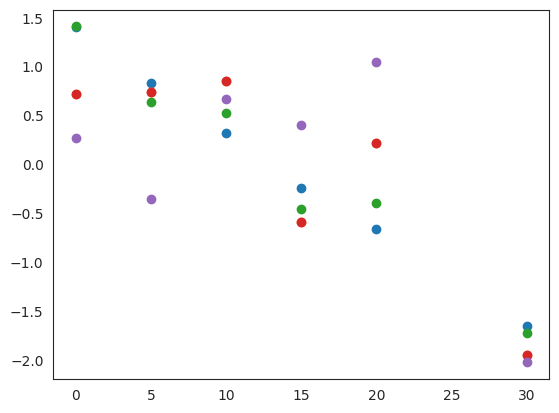

In [114]:
timepoints = [0, 5, 10, 15, 20, 30] # somites
plt.scatter(timepoints, genes_by_dataset_sampled.loc["myf5"])
plt.scatter(timepoints, genes_by_dataset_sampled.loc["meox1"])
plt.scatter(timepoints, genes_by_dataset_sampled.loc["her1"])
plt.scatter(timepoints, genes_by_dataset_sampled.loc["meox1"])

plt.scatter(timepoints, genes_by_dataset_sampled.loc["hbbe1.1"])

In [35]:
# Perform hierarchical clustering on the genes (rows)
# Use 'ward' linkage method as an example; you can experiment with other methods like 'single', 'complete', etc.
linkage_matrix = linkage(genes_by_dataset, method='ward', metric='euclidean')

# Generate a dendrogram to get the order of rows after clustering
dendro = dendrogram(linkage_matrix, no_plot=True)  # Set `no_plot=True` since we only need the order

# Get the order of rows according to the clustering
row_order = dendro['leaves']

In [36]:
# Reorder the genes_by_dataset DataFrame according to the clustering result
genes_by_dataset_clustered = genes_by_dataset.iloc[row_order, :]

# Now, genes_by_dataset_clustered has the rows (genes) reordered based on their clustering

In [45]:
genes_subset_clustered.head(50)

dataset,TDR126,TDR127,TDR128,TDR118_TDR119_reseq_avg,TDR125reseq,TDR124reseq
mt-nd6,2.528167,2.929228,2.484257,2.404790,2.623016,3.213551
gse1,2.235638,2.278198,2.348984,2.396514,2.497513,2.534156
mt-nd4,3.188570,3.598017,3.142279,3.116277,3.302670,3.937865
mt-nd5,3.244055,3.658834,3.201706,3.143047,3.340081,3.965087
mt-co1,3.218442,3.627696,3.173682,3.168615,3.334655,3.966897
mt-atp8,2.777127,3.185097,2.734809,2.690465,2.920023,3.518038
mt-nd3,2.886192,3.289121,2.833458,2.827205,3.017005,3.643798
mt-nd4l,2.854369,3.256618,2.805676,2.793847,2.978828,3.608102
mt-co2,2.977765,3.389056,2.938229,2.902097,3.117679,3.733301
mt-atp6,2.961935,3.374560,2.918733,2.887464,3.105637,3.713410


In [18]:
# # Example: Selecting the top N genes with the highest variance
# N = 500  # Number of genes to select

# # compute the variance (over timepoints)
# variances = genes_by_dataset.var(axis=1)

# # select the genes with top 400 and bottom 100 variances
# top_genes = variances.nlargest(N-100).index
# bottom_genes = variances.nsmallest(100).index

# # join the indices
# selected_genes = top_genes.append(bottom_genes)
# # subset the genes
# genes_subset = genes_by_dataset.loc[selected_genes]

# # Perform hierarchical clustering on the subset
# linkage_matrix = linkage(genes_subset, method='ward', metric='euclidean')
# dendro = dendrogram(linkage_matrix, no_plot=True)
# row_order = dendro['leaves']

# # Reorder the subsetted genes based on the clustering
# genes_subset_clustered = genes_subset.iloc[row_order]

# # Apply z-score normalization across rows (genes)
# genes_subset_clustered_zscored = genes_subset_clustered.apply(zscore, axis=1)

# # Find suitable vmin and vmax values, for example, the 5th and 95th percentiles
# vmin, vmax = np.percentile(genes_subset_clustered_zscored.values, [5, 95])

# # Plotting the heatmap with reordered genes
# plt.figure(figsize=(12, 10))  # Adjust size as needed
# sns.heatmap(genes_subset_clustered, cmap="viridis", vmin=vmin, vmax=vmax,
#             linewidths=0.05, xticklabels=True, yticklabels=False)
# plt.title('Gene Expression Heatmap of Top Varied Genes by Dataset (Clustered)')
# plt.xlabel('Dataset')
# plt.ylabel('Gene (Clustered)')
# plt.show()

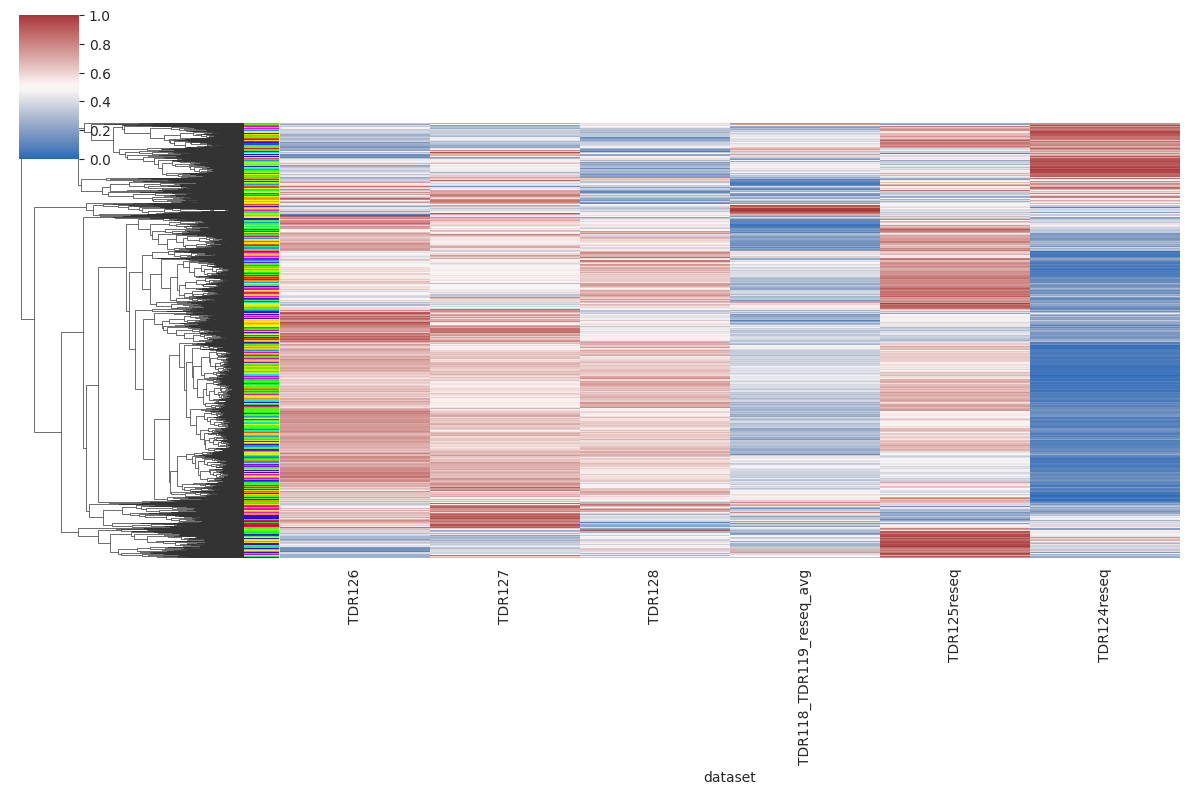

In [53]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster


# Step 1: Normalize the data (z-score for each gene)
genes_by_dataset_zscored = genes_by_dataset.apply(zscore, axis=1)

# Step 2: Cluster the genes
# Check for non-finite values (NaN, Inf, -Inf) in the DataFrame
if not np.all(np.isfinite(genes_by_dataset_zscored)):
    # Replace non-finite values with zero or another suitable value
    genes_by_dataset_zscored = genes_by_dataset_zscored.replace([np.inf, -np.inf], np.nan)
    # You can fill NaN values with zero or some other imputation method
    genes_by_dataset_zscored = genes_by_dataset_zscored.fillna(0)

# Proceed with clustering now that the data contains only finite values
linkage_matrix = linkage(genes_by_dataset_zscored, method='ward')
gene_order = leaves_list(linkage_matrix)
genes_by_dataset_clustered = genes_by_dataset_zscored.iloc[gene_order]


# Step 3: Determine clusters for the side color bar
gene_clusters = fcluster(linkage_matrix, t=20, criterion='maxclust')
cluster_colors = sns.color_palette("hsv", np.unique(gene_clusters).max())
row_colors = pd.Series(gene_clusters, index=genes_by_dataset_clustered.index).map(dict(zip(np.unique(gene_clusters), cluster_colors)))

# Step 4: Generate the heatmap
sns.clustermap(genes_by_dataset_clustered,
               row_cluster=True, col_cluster=False,
               standard_scale=1, # Normalize across rows
               row_colors=row_colors, # Add cluster colors
               cmap="vlag", # Use a diverging color palette
               linewidths=0.0, # No lines between cells
               figsize=(12, 8), # Adjust the figure size to your data
               xticklabels=True, yticklabels=False) # Remove gene labels for clarity

plt.show()

### heatmaps: genes-by-timepoints (group.by celltype)



In [19]:
# compute the "mean" gene.activity across all cells per dataset
# Compute the mean gene activity across all cells per dataset and celltype
dataset_by_genes_celltypes = count_matrice.groupby(["dataset", "celltype"]).mean()
dataset_by_genes_celltypes

ptpn12     phtf2   phtf2.1  CU856344.1  \
dataset     celltype                                                            
TDR118reseq Adaxial_Cells            0.063972  0.618095  0.204793    0.259467   
            Differentiating_Neurons  0.158203  0.150203  0.091587    0.258033   
            Endoderm                 0.138783  0.138304  0.086597    0.308072   
            Epidermal                0.124154  0.158576  0.081674    0.218883   
            Lateral_Mesoderm         0.124425  0.171440  0.090809    0.228534   
...                                       ...       ...       ...         ...   
TDR128      Neural_Posterior         0.153317  0.182988  0.096959    0.267798   
            Notochord                0.217886  0.348616  0.129651    0.084565   
            PSM                      0.180757  0.211572  0.078762    0.264705   
            Somites                  0.155797  0.320995  0.120556    0.224886   
            unassigned               0.163173  0.189930  0.088083    0.245660   

                                     si:zfos-932h1.3    mansc1      lrp6  \
dataset     celltype                                                       
TDR118reseq Adaxial_Cells                   0.561751  0.089702  0.131933   
            Differentiating_Neurons         0.665756  0.084097  0.180787   
            Endoderm                        0.671856  0.082609  0.147244   
            Epidermal                       0.592211  0.051766  0.114278   
            Lateral_Mesoderm                0.683412  0.066581  0.131499   
...                                              ...       ...       ...   
TDR128      Neural_Posterior                0.714959  0.062820  0.196121   
            Notochord                       0.578486  0.047616  0.149909   
            PSM                             0.796188  0.084623  0.174032   
            Somites                         0.758148  0.085892  0.143198   
            unassigned                      0.731787  0.062663  0.150068   

                                       dusp16    crebl2     gpr19  ...  \
dataset     celltype                                               ...   
TDR118reseq Adaxial_Cells            0.426991  0.367395  0.230990  ...   
            Differentiating_Neurons  0.353955  0.311638  0.262896  ...   
            Endoderm                 0.384135  0.285425  0.271700  ...   
            Epidermal                0.365044  0.281441  0.228549  ...   
            Lateral_Mesoderm         0.365649  0.288235  0.220282  ...   
...                                       ...       ...       ...  ...   
TDR128      Neural_Posterior         0.412269  0.349600  0.357908  ...   
            Notochord                0.407712  0.282729  0.328683  ...   
            PSM                      0.432899  0.350171  0.339006  ...   
            Somites                  0.411310  0.333698  0.338267  ...   
            unassigned               0.393310  0.323903  0.329015  ...   

                                       mt-co2   mt-atp8   mt-atp6    mt-co3  \
dataset     celltype                                                          
TDR118reseq Adaxial_Cells            2.918364  2.680605  2.859680  2.918494   
            Differentiating_Neurons  3.034844  2.820959  3.022728  3.091478   
            Endoderm                 2.935251  2.697955  2.898986  2.986401   
            Epidermal                3.225680  3.011312  3.216441  3.278679   
            Lateral_Mesoderm         3.025420  2.808194  3.010771  3.074257   
...                                       ...       ...       ...       ...   
TDR128      Neural_Posterior         3.018939  2.809586  2.994456  3.042761   
            Notochord                2.963527  2.752177  2.954537  2.995664   
            PSM                      2.755251  2.557674  2.751152  2.812437   
            Somites                  2.972321  2.768572  2.958235  3.010581   
            unassigned               3.320165  3.108078  3.296425  3.352513   

     

In [20]:
# Assuming dataset_by_genes_celltypes has a MultiIndex with 'dataset' and 'celltype'
# Extract the rows for 'TDR118reseq' and 'TDR119reseq' into separate DataFrames
reseq118_df = dataset_by_genes_celltypes.xs('TDR118reseq', level='dataset')
reseq119_df = dataset_by_genes_celltypes.xs('TDR119reseq', level='dataset')

# Calculate the mean of these two DataFrames
reseq_mean_df = (reseq118_df + reseq119_df) / 2

# Now, create a new combined entry in the original DataFrame
# First, remove the old 'TDR118reseq' and 'TDR119reseq' entries to avoid duplication
dataset_by_genes_celltypes = dataset_by_genes_celltypes[~dataset_by_genes_celltypes.index.get_level_values('dataset').isin(['TDR118reseq', 'TDR119reseq'])]

# Then, append the new average DataFrame to the original DataFrame
# We need to give this new DataFrame an appropriate MultiIndex
reseq_mean_df.index = pd.MultiIndex.from_product([['TDR118_TDR119_reseq_avg'], reseq_mean_df.index], names=['dataset', 'celltype'])
dataset_by_genes_celltypes = pd.concat([dataset_by_genes_celltypes, reseq_mean_df])
dataset_by_genes_celltypes

ptpn12     phtf2   phtf2.1  \
dataset                 celltype                                                
TDR124reseq             Adaxial_Cells            0.092916  0.229528  0.177717   
                        Differentiating_Neurons  0.133071  0.163772  0.081007   
                        Endoderm                 0.172232  0.163424  0.115097   
                        Epidermal                0.090703  0.120895  0.074003   
                        Lateral_Mesoderm         0.039167  0.221295  0.094662   
...                                                   ...       ...       ...   
TDR118_TDR119_reseq_avg Neural_Posterior         0.132231  0.163407  0.091667   
                        Notochord                0.135003  0.239752  0.120605   
                        PSM                      0.121498  0.192798  0.087561   
                        Somites                  0.115011  0.281579  0.120672   
                        unassigned               0.115523  0.162323  0.073415   

                                                 CU856344.1  si:zfos-932h1.3  \
dataset                 celltype                                               
TDR124reseq             Adaxial_Cells              0.167875         0.646461   
                        Differentiating_Neurons    0.221602         0.695108   
                        Endoderm                   0.274827         0.777767   
                        Epidermal                  0.183534         0.708328   
                        Lateral_Mesoderm           0.246240         0.852024   
...                                                     ...              ...   
TDR118_TDR119_reseq_avg Neural_Posterior           0.245281         0.621921   
                        Notochord                  0.171649         0.543918   
                        PSM                        0.218744         0.614135   
                        Somites                    0.238236         0.640455   
                        unassigned                 0.238953         0.656756   

                                                   mansc1      lrp6    dusp16  \
dataset                 celltype                                                
TDR124reseq             Adaxial_Cells            0.052206  0.128758  0.341495   
                        Differentiating_Neurons  0.095846  0.144339  0.286721   
                        Endoderm                 0.046378  0.102901  0.375564   
                        Epidermal                0.049445  0.136967  0.300751   
                        Lateral_Mesoderm         0.097005  0.167772  0.291096   
...                                                   ...       ...       ...   
TDR118_TDR119_reseq_avg Neural_Posterior         0.065908  0.167674  0.343504   
                        Notochord                0.102659  0.174482  0.360523   
                        PSM                      0.069749  0.143777  0.373436   
                        Somites                  0.077297  0.107499  0.337753   
                        unassigned               0.066687  0.099980  0.328260   

                                                   crebl2     gpr19  ...  \
dataset                 celltype                                     ...   
TDR124reseq             Adaxial_Cells            0.219853  0.107759  ...   
                        Differentiating_Neurons  0.260406  0.168896  ...   
                        Endoderm                 0.253536  0.104131  ...   
                        Epidermal                0.215783  0.099033  ...   
                        Lateral_Mesoderm         0.204672  0.120701  ...   
...                                                   ...       ...  ...   
TDR118_TDR119_reseq_avg Neural_Posterior         0.286809  0.162348  ...   
                        Notochord                0.307186  0.185780  ...   
                        PSM                      0.303524  0.155231  ...   
                        Somites                  0.265788  0.15456

In [27]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster
from scipy.stats import zscore

# Assuming dataset_by_genes_celltypes is your DataFrame
# Normalize the data if needed
datset_by_genes_celltypes_normalized = dataset_by_genes_celltypes.apply(zscore,axis=1)

# Replace any remaining Inf/-Inf with NaN
datset_by_genes_celltypes_normalized.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with column means or another appropriate value
datset_by_genes_celltypes_normalized.fillna(datset_by_genes_celltypes_normalized.mean(), inplace=True)

# Ensure there are no more non-finite values
assert np.all(np.isfinite(datset_by_genes_celltypes_normalized)), "There are still non-finite values in the DataFrame!"

# Perform hierarchical clustering
# Row clustering (genes)
#row_linkage = linkage(genes_by_dataset_celltypes_normalized, method='average', metric='correlation')
row_linkage = linkage(datset_by_genes_celltypes_normalized.T, method='average', metric='correlation')
# Column clustering (timepoints)
col_linkage = linkage(datset_by_genes_celltypes_normalized, method='average', metric='correlation')


# Assuming 'linkage_matrix' is the result of your hierarchical clustering from before
# Determine clusters (set a threshold or specify the number of clusters)
gene_clusters = fcluster(row_linkage, t=20, criterion='maxclust')

# Create a mapping from clusters to colors
# Here we use a seaborn color palette, but you can choose any color palette you like
unique_clusters = np.unique(gene_clusters)
cluster_colors = sns.color_palette("hsv", len(unique_clusters))
cluster_color_map = dict(zip(unique_clusters, cluster_colors))

# Map the gene clusters to colors for the row_colors in clustermap
row_colors = pd.Series(gene_clusters, index=datset_by_genes_celltypes_normalized.index).map(cluster_color_map)
# Clustermap with Seaborn
sns.clustermap(datset_by_genes_celltypes_normalized, 
               row_linkage=row_linkage, 
               col_linkage=col_linkage, 
               method='average', 
               cmap='vlag', 
               row_colors=row_colors,  # Add the row colors if you have a specific celltype color mapping
               figsize=(12, 12),  # Adjust the figure size appropriately
               cbar_pos=(1.0, 0.2, 0.03, 0.4))  # Adjust the color bar position

plt.show()

ValueError: Length of values (25032) does not match length of index (84)

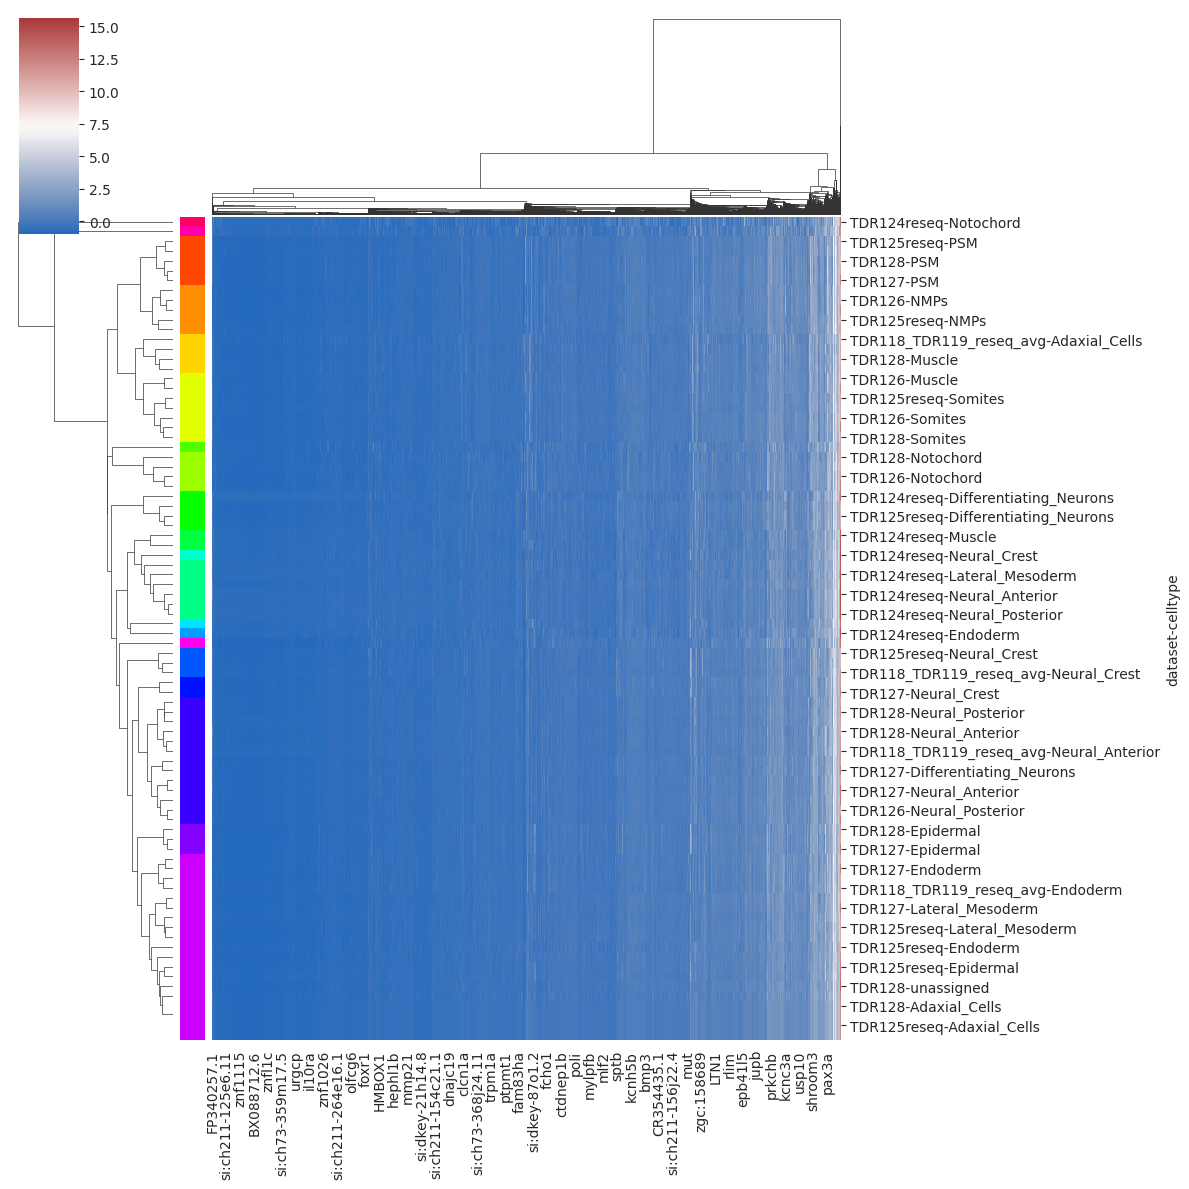

In [35]:
# Assuming that genes_by_dataset_celltypes_normalized is the DataFrame you want to cluster
# Recompute the linkage matrix, making sure to cluster the genes (rows)
row_linkage = linkage(datset_by_genes_celltypes_normalized, method='average', metric='correlation')

# Create clusters
gene_clusters = fcluster(row_linkage, t=20, criterion='maxclust')

# Now, map the clusters to colors
unique_clusters = np.unique(gene_clusters)
cluster_colors = sns.color_palette("hsv", len(unique_clusters))
cluster_color_map = dict(zip(unique_clusters, cluster_colors))

# Generate row_colors for the heatmap
row_colors = pd.Series(gene_clusters, index=datset_by_genes_celltypes_normalized.index).map(cluster_color_map)

# Now plot the clustermap with the row_colors included
sns.clustermap(datset_by_genes_celltypes_normalized, 
               row_linkage=row_linkage, 
               col_linkage=None,  # No column clustering
               cmap='vlag', 
               row_colors=row_colors,  # Add row colors
               figsize=(12, 12))  # Adjust figure size as needed

plt.show()

The above heatmap needs to be fixed later. (**HOLD as of 2/28/2024**)

## genes-by-timepoints (grouped.by celltypes)

- last updated: 02/28/2024



In [115]:
count_matrice_NMPs = count_matrice[count_matrice.celltype=="NMPs"]
count_matrice_NMPs

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb,dataset,celltype
AAACCGCGTTATCCGT-1,0.000000,0.878613,0.000000,0.532849,0.532849,0.878613,0.000000,0.000000,0.000000,0.532849,...,3.464682,3.569115,3.419651,3.372495,3.588754,3.442420,2.802338,3.297311,TDR118reseq,NMPs
AACTAGCTCAGGGCCT-1,0.000000,0.318686,0.000000,0.754222,0.916801,0.000000,0.318686,0.754222,0.559980,0.754222,...,3.570359,3.591266,3.434810,3.385212,3.591266,3.559739,2.674940,3.173647,TDR118reseq,NMPs
AAGCCACGTACTGATG-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.548934,1.548934,0.000000,...,4.268613,4.413306,4.367362,4.268613,4.539684,4.720225,3.968220,4.539684,TDR118reseq,NMPs
AATCATGTCGATTTGA-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.629573,0.629573,0.629573,...,3.931396,4.060315,4.075321,4.104674,4.324513,4.369903,3.822475,4.324513,TDR118reseq,NMPs
AATGGCGCAGCTAACC-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.538768,3.650033,3.446359,3.379639,3.650033,3.773686,3.190306,3.796682,TDR118reseq,NMPs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCACCCAGGCGAGT-1,0.000000,0.000000,0.000000,0.326936,0.934857,0.000000,0.572913,1.409449,0.572913,0.770172,...,2.933260,3.120420,3.085686,3.067856,3.375196,3.426763,2.869525,3.320825,TDR128,NMPs
TTTCAGTTCATAGCCG-1,0.321122,0.321122,0.321122,0.321122,0.922151,0.000000,0.321122,0.000000,0.563805,1.185413,...,0.321122,0.563805,0.758944,0.758944,0.563805,0.000000,0.321122,0.321122,TDR128,NMPs
TTTCCTGAGTGAACAG-1,0.000000,0.388423,0.000000,0.212953,0.388423,0.000000,0.212953,0.388423,0.212953,0.212953,...,2.394957,2.497688,2.327838,2.416365,2.827366,2.921126,2.304425,2.739351,TDR128,NMPs
TTTGACTTCATCCTAT-1,0.000000,0.000000,0.000000,0.474942,0.924181,0.000000,0.000000,0.924181,0.648088,0.265406,...,2.078328,2.252438,2.115659,2.039548,2.427865,2.372740,1.819266,2.219957,TDR128,NMPs


In [160]:
count_matrice.loc[:,"celltype"].unique()

array(['Epidermal', 'Lateral_Mesoderm', 'PSM', 'Neural_Posterior',
       'Muscle', 'Neural_Anterior', 'Neural_Crest',
       'Differentiating_Neurons', 'Adaxial_Cells', 'Somites', 'NMPs',
       'Endoderm', 'Notochord', 'unassigned'], dtype=object)

(array([600.,   0.,   4.,  29.,  75., 110.,  91., 102.,  93.,  90.,  71.,
         84.,  67.,  47.,  42.,  31.,  23.,  24.,  14.,  12.,   7.,   4.,
          1.,   3.,   3.,   7.,   1.,   1.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.06466591, 0.12933183, 0.19399774, 0.25866365,
        0.32332957, 0.38799548, 0.4526614 , 0.51732731, 0.58199322,
        0.64665914, 0.71132505, 0.77599096, 0.84065688, 0.90532279,
        0.9699887 , 1.03465462, 1.09932053, 1.16398644, 1.22865236,
        1.29331827, 1.35798419, 1.4226501 , 1.48731601, 1.55198193,
        1.61664784, 1.68131375, 1.74597967, 1.81064558, 1.87531149,
        1.93997741, 2.00464344, 2.06930923, 2.13397503, 2.19864106,
        2.26330709, 2.32797289, 2.39263868, 2.45730472, 2.52197075,
        2.58663654]),
 <BarContainer object of 40 artists>)

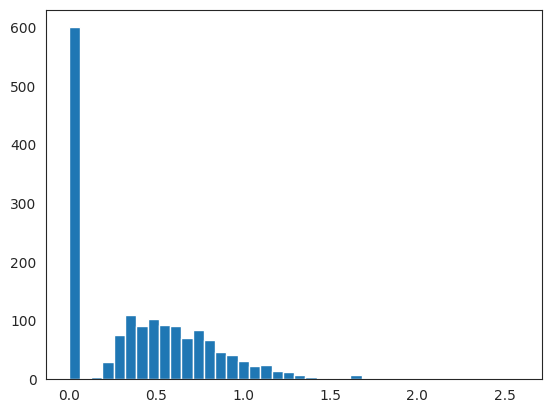

In [128]:
plt.hist(count_matrice_NMPs.loc[:,"sox2"], bins=40)

In [132]:
print(count_matrice_NMPs.loc[:,"sox2"].mean())
print(count_matrice_NMPs.loc[:,"sox2"].median())
print(count_matrice_NMPs.loc[:,"sox2"][count_matrice_NMPs.loc[:,"sox2"]!=0].mean())

0.40821263
0.38843834
0.64394665


In [137]:
# compute the "mean" gene.activity across all cells per dataset
# here, we have multiple choices - (1) mean, (2) median, (3) mean excluding zeros, etc.
# From the quick exploration, it seems like that the mean and median underestimates the real mean of the distribution as the data is highly sparse (skewed towards zeros)

# replace the zeros in the count matrix to "NaN" to compute the mean excluding zeros
count_matrice_NMPs[count_matrice_NMPs==0] = np.nan
count_matrice_NMPs

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb,dataset,celltype
AAACCGCGTTATCCGT-1,NaN,0.878613,NaN,0.532849,0.532849,0.878613,NaN,NaN,NaN,0.532849,...,3.464682,3.569115,3.419651,3.372495,3.588754,3.442420,2.802338,3.297311,TDR118reseq,NMPs
AACTAGCTCAGGGCCT-1,NaN,0.318686,NaN,0.754222,0.916801,NaN,0.318686,0.754222,0.559980,0.754222,...,3.570359,3.591266,3.434810,3.385212,3.591266,3.559739,2.674940,3.173647,TDR118reseq,NMPs
AAGCCACGTACTGATG-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.548934,1.548934,NaN,...,4.268613,4.413306,4.367362,4.268613,4.539684,4.720225,3.968220,4.539684,TDR118reseq,NMPs
AATCATGTCGATTTGA-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.629573,0.629573,0.629573,...,3.931396,4.060315,4.075321,4.104674,4.324513,4.369903,3.822475,4.324513,TDR118reseq,NMPs
AATGGCGCAGCTAACC-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.538768,3.650033,3.446359,3.379639,3.650033,3.773686,3.190306,3.796682,TDR118reseq,NMPs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCACCCAGGCGAGT-1,NaN,NaN,NaN,0.326936,0.934857,NaN,0.572913,1.409449,0.572913,0.770172,...,2.933260,3.120420,3.085686,3.067856,3.375196,3.426763,2.869525,3.320825,TDR128,NMPs
TTTCAGTTCATAGCCG-1,0.321122,0.321122,0.321122,0.321122,0.922151,NaN,0.321122,NaN,0.563805,1.185413,...,0.321122,0.563805,0.758944,0.758944,0.563805,NaN,0.321122,0.321122,TDR128,NMPs
TTTCCTGAGTGAACAG-1,NaN,0.388423,NaN,0.212953,0.388423,NaN,0.212953,0.388423,0.212953,0.212953,...,2.394957,2.497688,2.327838,2.416365,2.827366,2.921126,2.304425,2.739351,TDR128,NMPs
TTTGACTTCATCCTAT-1,NaN,NaN,NaN,0.474942,0.924181,NaN,NaN,0.924181,0.648088,0.265406,...,2.078328,2.252438,2.115659,2.039548,2.427865,2.372740,1.819266,2.219957,TDR128,NMPs


In [138]:
# compute the "mean" gene.activity across all cells per dataset
# here, we have multiple choices - (1) mean, (2) median, (3) mean excluding zeros, etc.
# From the quick exploration, it seems like that the mean and median underestimates the real mean of the distribution as the data is highly sparse (skewed towards zeros)
dataset_by_genes_NMPs = count_matrice_NMPs.groupby("dataset").mean()
dataset_by_genes_NMPs

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-co2,mt-atp8,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb
dataset,,,,,,,,,,,,,,,,,,,,,
TDR118reseq,0.614251,0.628874,0.669118,0.611950,0.960417,0.540611,0.560751,0.679499,0.652352,0.627903,...,3.115890,2.887780,3.107575,3.189180,3.075365,3.075633,3.383039,3.371057,2.688387,3.176372
TDR119reseq,0.639114,0.569649,0.533796,0.710820,0.972902,0.640453,0.588670,0.793887,0.742450,0.554930,...,2.615389,2.399436,2.596071,2.637366,2.530030,2.493047,2.829268,2.853093,2.240417,2.709523
TDR124reseq,0.373152,0.690292,0.763317,0.688169,0.926417,0.619687,0.504424,0.816262,0.789817,0.707396,...,3.315296,3.129707,3.341589,3.323463,3.166271,3.120652,3.470957,3.489452,2.900324,3.376076
TDR125reseq,0.410321,0.500970,0.395033,0.481273,0.862032,0.428130,0.379838,0.570993,0.536342,0.568038,...,3.073164,2.883464,3.047044,3.087526,2.956825,2.909292,3.233966,3.267554,2.572590,3.078348
TDR126,0.505633,0.546834,0.493407,0.590167,0.964464,0.439118,0.547642,0.700633,0.657612,0.841414,...,2.805019,2.606814,2.786939,2.839158,2.708266,2.675914,3.007296,3.069134,2.361612,2.887086
TDR127,0.516915,0.572717,0.517205,0.610218,0.947192,0.484623,0.556935,0.687093,0.606775,0.706696,...,3.252125,3.058389,3.236666,3.283309,3.147844,3.115640,3.448580,3.510925,2.793751,3.322645
TDR128,0.496105,0.505002,0.425903,0.545419,0.910276,0.445914,0.540898,0.628870,0.616834,0.673605,...,2.735094,2.523802,2.711541,2.755119,2.631877,2.617525,2.944292,3.022141,2.279509,2.810429


In [140]:
dataset_by_genes_NMPs.loc[:,"sox2"]

dataset
TDR118reseq    0.775248
TDR119reseq    0.746887
TDR124reseq    1.015203
TDR125reseq    0.590559
TDR126         0.634590
TDR127         0.631153
TDR128         0.636045
Name: sox2, dtype: float32

In [141]:
# Calculate the mean of the counts for TDR118reseq and TDR119reseq
mean_TDR118_TDR119_reseq = dataset_by_genes_NMPs.loc[['TDR118reseq', 'TDR119reseq']].mean(axis=0)

# Add the mean as a new row in the dataset_by_genes DataFrame
dataset_by_genes_NMPs.loc['TDR118_TDR119_reseq_avg'] = mean_TDR118_TDR119_reseq

# Optionally, if you want to remove the original TDR118reseq and TDR119reseq rows
dataset_by_genes_NMPs = dataset_by_genes_NMPs.drop(['TDR118reseq', 'TDR119reseq'])

dataset_by_genes_NMPs

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-co2,mt-atp8,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb
dataset,,,,,,,,,,,,,,,,,,,,,
TDR124reseq,0.373152,0.690292,0.763317,0.688169,0.926417,0.619687,0.504424,0.816262,0.789817,0.707396,...,3.315296,3.129707,3.341589,3.323463,3.166271,3.120652,3.470957,3.489452,2.900324,3.376076
TDR125reseq,0.410321,0.500970,0.395033,0.481273,0.862032,0.428130,0.379838,0.570993,0.536342,0.568038,...,3.073164,2.883464,3.047044,3.087526,2.956825,2.909292,3.233966,3.267554,2.572590,3.078348
TDR126,0.505633,0.546834,0.493407,0.590167,0.964464,0.439118,0.547642,0.700633,0.657612,0.841414,...,2.805019,2.606814,2.786939,2.839158,2.708266,2.675914,3.007296,3.069134,2.361612,2.887086
TDR127,0.516915,0.572717,0.517205,0.610218,0.947192,0.484623,0.556935,0.687093,0.606775,0.706696,...,3.252125,3.058389,3.236666,3.283309,3.147844,3.115640,3.448580,3.510925,2.793751,3.322645
TDR128,0.496105,0.505002,0.425903,0.545419,0.910276,0.445914,0.540898,0.628870,0.616834,0.673605,...,2.735094,2.523802,2.711541,2.755119,2.631877,2.617525,2.944292,3.022141,2.279509,2.810429
TDR118_TDR119_reseq_avg,0.626682,0.599261,0.601457,0.661385,0.966659,0.590532,0.574711,0.736693,0.697401,0.591416,...,2.865639,2.643608,2.851823,2.913273,2.802698,2.784340,3.106153,3.112075,2.464402,2.942947


In [142]:
# Transpose dataset_by_genes so genes are rows and datasets are columns
genes_by_dataset_NMPs = dataset_by_genes_NMPs.T

# Define your specific order for datasets
specific_order = ["TDR126", "TDR127", "TDR128", "TDR118_TDR119_reseq_avg", "TDR125reseq", "TDR124reseq"]

# Reorder the columns of genes_by_dataset according to specific_order
genes_by_dataset_NMPs = genes_by_dataset_NMPs[specific_order]

In [156]:
# subset the genes for the highly variables genes (3000, as the total number of genes is 25K)
list_hvg = list(set(genes_by_dataset_NMPs.index).intersection(set(list_hvg_RNA)))
genes_subset = genes_by_dataset_NMPs.loc[list_hvg]
genes_subset

dataset,TDR126,TDR127,TDR128,TDR118_TDR119_reseq_avg,TDR125reseq,TDR124reseq
tmem178b,0.673980,0.716429,0.732210,0.813711,0.597130,0.953304
otpa,0.551939,0.537274,0.550502,0.631380,0.492327,0.774927
gpc1b,0.507830,0.588121,0.533545,0.738266,0.486177,0.939641
spaca4l,0.467652,0.483665,0.384523,0.497663,0.399759,0.719123
agrn,1.779078,1.878440,2.018263,2.015431,2.000505,1.983593
...,...,...,...,...,...,...
en1a,0.517712,0.513255,0.462260,0.564577,0.505335,0.518639
thsd7ba,0.901402,0.952497,0.951100,1.102158,0.933491,1.247570
scube1,1.015842,1.053840,1.068905,1.105200,1.022247,1.070074
gpc5a,0.822233,0.894587,0.932813,1.061617,1.044654,1.172634


In [154]:
count_matrice_NMPs[count_matrice_NMPs.loc[:,"dataset"]=="TDR124reseq"].loc[:,"myf5"]

AACAGATAGCAAGGGT-1   NaN
ACCCAACCACATACTG-1   NaN
AGGGCCTTCCTTGTTG-1   NaN
AGTTTGATCTTAAGTG-1   NaN
CAAGGCCTCACAGCCA-1   NaN
CGGGACAAGGCTACAT-1   NaN
CTGTATTTCCCTCACG-1   NaN
GCATTGCCATGAGTTT-1   NaN
TATTTGGAGTCAATTG-1   NaN
TGAGCAAAGGCGCACT-1   NaN
TTCCTTGAGTCACGAT-1   NaN
TTGCAATCACCATATG-1   NaN
TTGCAGCCACGTGCTG-1   NaN
TTTCCTGAGTGAACAG-1   NaN
Name: myf5, dtype: float32

In [151]:
genes_by_dataset_NMPs[genes_by_dataset_NMPs.index=="myf5"]

dataset,TDR126,TDR127,TDR128,TDR118_TDR119_reseq_avg,TDR125reseq,TDR124reseq
myf5,0.519178,0.526647,0.467915,0.721515,0.532107,NaN


In [179]:
genes_by_dataset_zscored = genes_subset.apply(zscore, axis=1)
genes_by_dataset_zscored

dataset,TDR126,TDR127,TDR128,TDR118_TDR119_reseq_avg,TDR125reseq,TDR124reseq
tmem178b,-0.549866,-0.200704,-0.562242,1.121649,-1.330055,1.521219
otpa,-0.591127,-0.507792,-0.280573,1.026640,-1.272322,1.625178
gpc1b,-0.624988,-0.271028,-0.671492,0.663199,-1.003233,1.907543
spaca4l,-0.613795,-0.505313,-0.552581,0.809849,-0.989524,1.851366
agrn,0.181953,-0.404052,0.716722,1.018340,0.490190,-2.003158
...,...,...,...,...,...,...
en1a,-0.224002,-0.294869,-0.687349,0.799877,-1.324581,1.730927
thsd7ba,0.367488,0.751158,0.453485,0.892914,-2.026104,-0.438944
scube1,0.797326,-0.302029,-0.202422,0.900161,-1.958523,0.765489
gpc5a,-0.973357,-0.257430,-1.063233,0.525957,-0.120003,1.888070


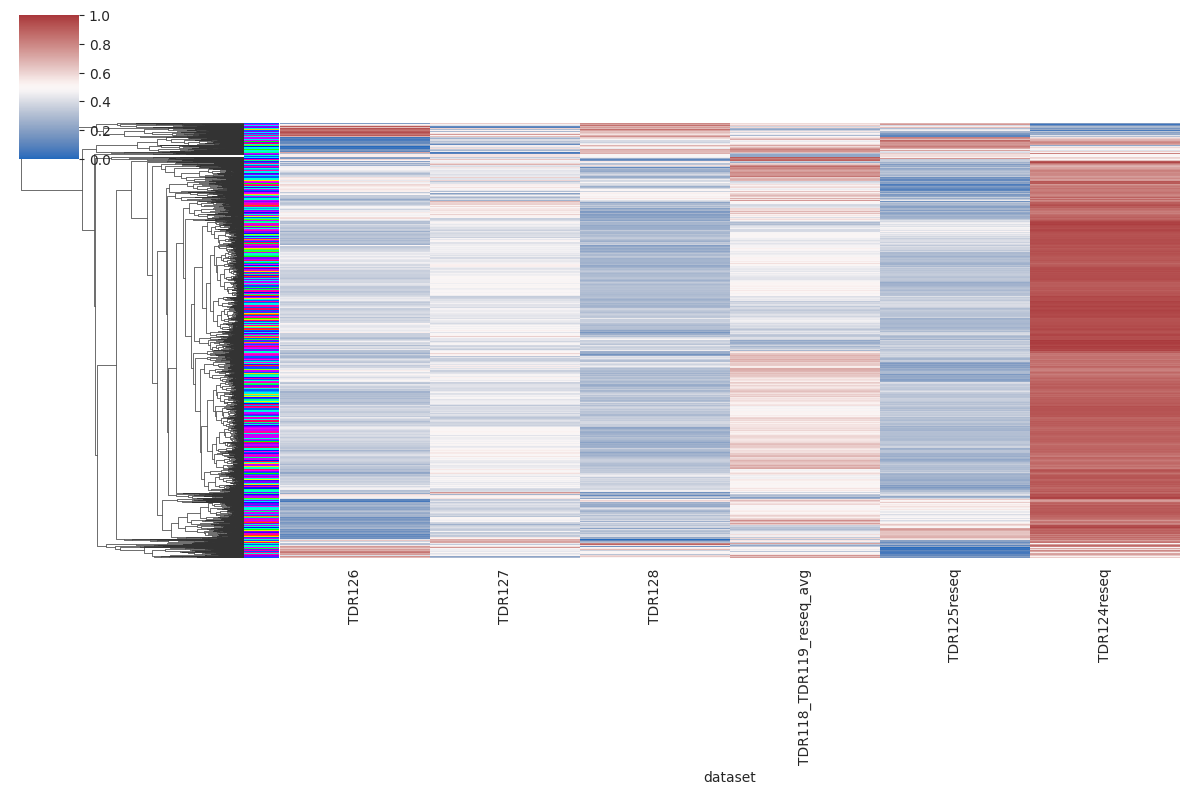

In [180]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster


# Step 1: Normalize the data (z-score for each gene)
genes_by_dataset_zscored = genes_subset.apply(zscore, axis=1)

# Step 2: Cluster the genes
# Check for non-finite values (NaN, Inf, -Inf) in the DataFrame
if not np.all(np.isfinite(genes_by_dataset_zscored)):
    # Replace non-finite values with zero or another suitable value
    genes_by_dataset_zscored = genes_by_dataset_zscored.replace([np.inf, -np.inf], np.nan)
    # You can fill NaN values with zero or some other imputation method
    genes_by_dataset_zscored = genes_by_dataset_zscored.fillna(0)

# Proceed with clustering now that the data contains only finite values
linkage_matrix = linkage(genes_by_dataset_zscored, method='ward')
gene_order = leaves_list(linkage_matrix)
genes_by_dataset_clustered = genes_by_dataset_zscored.iloc[gene_order]


# Step 3: Determine clusters for the side color bar
gene_clusters = fcluster(linkage_matrix, t=20, criterion='maxclust')
cluster_colors = sns.color_palette("hsv", np.unique(gene_clusters).max())
row_colors = pd.Series(gene_clusters, index=genes_by_dataset_clustered.index).map(dict(zip(np.unique(gene_clusters), cluster_colors)))

# Step 4: Generate the heatmap
sns.clustermap(genes_by_dataset_clustered,
               row_cluster=True, col_cluster=False,
               standard_scale=1, # Normalize across rows
               row_colors=row_colors, # Add cluster colors
               cmap="vlag", # Use a diverging color palette
               linewidths=0.0, # No lines between cells
               figsize=(12, 8), # Adjust the figure size to your data
               xticklabels=True, yticklabels=False) # Remove gene labels for clarity

plt.show()

## Other cell types

In [160]:
count_matrice.loc[:,"celltype"].unique()

array(['Epidermal', 'Lateral_Mesoderm', 'PSM', 'Neural_Posterior',
       'Muscle', 'Neural_Anterior', 'Neural_Crest',
       'Differentiating_Neurons', 'Adaxial_Cells', 'Somites', 'NMPs',
       'Endoderm', 'Notochord', 'unassigned'], dtype=object)

In [162]:
count_matrice_Somites = count_matrice[count_matrice.celltype=="Somites"]
count_matrice_Somites.head()

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb,dataset,celltype
AAACCGCGTTAGACCA-1,0.471101,0.000000,0.0,0.000000,0.790053,0.000000,0.000000,0.790053,0.471101,0.000000,...,2.915116,3.008462,2.775331,2.775331,3.197388,3.093834,2.106702,2.567649,TDR118reseq,Somites
AAACGCGCAACGTGCT-1,0.344046,0.802867,0.0,0.599544,0.802867,0.599544,0.000000,0.000000,0.344046,0.344046,...,2.619580,2.557899,2.589215,2.457599,2.784630,2.732583,1.707849,2.305996,TDR118reseq,Somites
AAACGTACAGCTAATT-1,0.000000,0.000000,0.0,0.000000,0.601066,0.000000,0.000000,0.601066,0.601066,0.000000,...,2.708654,3.033871,2.951225,2.993402,3.309448,3.110204,2.762105,3.110204,TDR118reseq,Somites
AAAGCAAGTTAGGCGT-1,0.539662,0.000000,0.0,0.389980,0.784987,0.213881,0.000000,0.389980,0.389980,0.213881,...,3.046043,3.122422,3.057318,2.950952,3.193378,3.183545,2.577353,2.975586,TDR118reseq,Somites
AAAGCACCAATTTAGC-1,0.000000,0.000000,0.0,0.000000,0.452235,0.000000,0.452235,0.452235,0.452235,0.000000,...,2.727560,2.649847,2.608602,2.473558,3.045176,3.148497,1.904821,2.689458,TDR118reseq,Somites


In [163]:
# compute the "mean" gene.activity across all cells per dataset
# here, we have multiple choices - (1) mean, (2) median, (3) mean excluding zeros, etc.
# From the quick exploration, it seems like that the mean and median underestimates the real mean of the distribution as the data is highly sparse (skewed towards zeros)

# replace the zeros in the count matrix to "NaN" to compute the mean excluding zeros
count_matrice_Somites[count_matrice_Somites==0] = np.nan
count_matrice_Somites

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb,dataset,celltype
AAACCGCGTTAGACCA-1,0.471101,NaN,NaN,NaN,0.790053,NaN,NaN,0.790053,0.471101,NaN,...,2.915116,3.008462,2.775331,2.775331,3.197388,3.093834,2.106702,2.567649,TDR118reseq,Somites
AAACGCGCAACGTGCT-1,0.344046,0.802867,NaN,0.599544,0.802867,0.599544,NaN,NaN,0.344046,0.344046,...,2.619580,2.557899,2.589215,2.457599,2.784630,2.732583,1.707849,2.305996,TDR118reseq,Somites
AAACGTACAGCTAATT-1,NaN,NaN,NaN,NaN,0.601066,NaN,NaN,0.601066,0.601066,NaN,...,2.708654,3.033871,2.951225,2.993402,3.309448,3.110204,2.762105,3.110204,TDR118reseq,Somites
AAAGCAAGTTAGGCGT-1,0.539662,NaN,NaN,0.389980,0.784987,0.213881,NaN,0.389980,0.389980,0.213881,...,3.046043,3.122422,3.057318,2.950952,3.193378,3.183545,2.577353,2.975586,TDR118reseq,Somites
AAAGCACCAATTTAGC-1,NaN,NaN,NaN,NaN,0.452235,NaN,0.452235,0.452235,0.452235,NaN,...,2.727560,2.649847,2.608602,2.473558,3.045176,3.148497,1.904821,2.689458,TDR118reseq,Somites
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTAAGGACCTTG-1,NaN,NaN,NaN,NaN,0.521447,NaN,NaN,NaN,NaN,NaN,...,3.160707,3.217122,3.131259,3.069628,3.689239,3.802333,2.687116,3.296192,TDR128,Somites
TTTGTGAAGTGACCTG-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.659327,0.953939,0.953939,...,3.461174,3.444333,3.461174,3.525838,3.736760,3.749358,2.949009,3.461174,TDR128,Somites
TTTGTGGCAAACAACA-1,NaN,0.468159,0.468159,NaN,0.785772,NaN,0.468159,0.468159,NaN,NaN,...,3.521578,3.622208,3.521578,3.539069,3.874674,3.923066,3.189858,3.823821,TDR128,Somites
TTTGTGTTCAAAGGCA-1,NaN,1.420191,0.836149,0.420672,0.943499,NaN,NaN,0.579126,0.232296,0.715872,...,2.392126,2.343125,2.086951,1.947955,2.237274,2.264806,1.786472,2.208963,TDR128,Somites


In [164]:
# compute the "mean" gene.activity across all cells per dataset
# here, we have multiple choices - (1) mean, (2) median, (3) mean excluding zeros, etc.
# From the quick exploration, it seems like that the mean and median underestimates the real mean of the distribution as the data is highly sparse (skewed towards zeros)
dataset_by_genes_Somites = count_matrice_Somites.groupby("dataset").mean()
dataset_by_genes_Somites.head()

,ptpn12,phtf2,phtf2.1,CU856344.1,si:zfos-932h1.3,mansc1,lrp6,dusp16,crebl2,gpr19,...,mt-co2,mt-atp8,mt-atp6,mt-co3,mt-nd3,mt-nd4l,mt-nd4,mt-nd5,mt-nd6,mt-cyb
dataset,,,,,,,,,,,,,,,,,,,,,
TDR118reseq,0.562612,0.758702,0.611596,0.660618,0.956152,0.594231,0.613866,0.751126,0.662822,0.614172,...,3.066289,2.863754,3.052766,3.118609,3.007831,2.963148,3.256995,3.268344,2.548521,3.063026
TDR119reseq,0.753290,0.841534,0.705121,0.811413,1.001693,0.680676,0.661137,0.794043,0.738170,0.711635,...,2.646076,2.448324,2.619667,2.663582,2.532177,2.517908,2.824944,2.879282,2.220398,2.678241
TDR124reseq,0.793506,0.972500,0.849080,0.844956,1.117600,0.691494,0.792652,0.761162,0.746424,0.775336,...,3.639210,3.423392,3.614430,3.664086,3.524652,3.502849,3.827478,3.874760,3.127364,3.682051
TDR125reseq,0.431365,0.622264,0.492036,0.521459,0.842141,0.425070,0.446106,0.613008,0.571205,0.621442,...,3.067380,2.878542,3.060473,3.106179,2.971442,2.928748,3.250177,3.280609,2.569646,3.075303
TDR126,0.473032,0.645036,0.530670,0.551891,0.995552,0.471162,0.519748,0.688698,0.649541,0.843544,...,2.896668,2.699181,2.875385,2.930501,2.806691,2.775144,3.107617,3.160327,2.445921,2.965680


In [165]:
dataset_by_genes_Somites.loc[:,"meox1"]

dataset
TDR118reseq    0.865518
TDR119reseq    0.921726
TDR124reseq    0.938345
TDR125reseq    0.695467
TDR126         0.722973
TDR127         0.744698
TDR128         0.814751
Name: meox1, dtype: float32

In [168]:
# Calculate the mean of the counts for TDR118reseq and TDR119reseq
mean_TDR118_TDR119_reseq = dataset_by_genes_Somites.loc[['TDR118reseq', 'TDR119reseq']].mean(axis=0)

# Add the mean as a new row in the dataset_by_genes DataFrame
dataset_by_genes_Somites.loc['TDR118_TDR119_reseq_avg'] = mean_TDR118_TDR119_reseq

# Optionally, if you want to remove the original TDR118reseq and TDR119reseq rows
dataset_by_genes_Somites = dataset_by_genes_Somites.drop(['TDR118reseq', 'TDR119reseq'])

dataset_by_genes_Somites

In [169]:
# Transpose dataset_by_genes so genes are rows and datasets are columns
genes_by_dataset_Somites = dataset_by_genes_Somites.T

# Define your specific order for datasets
specific_order = ["TDR126", "TDR127", "TDR128", "TDR118_TDR119_reseq_avg", "TDR125reseq", "TDR124reseq"]

# Reorder the columns of genes_by_dataset according to specific_order
genes_by_dataset_Somites = genes_by_dataset_Somites[specific_order]

In [170]:
# subset the genes for the highly variables genes (3000, as the total number of genes is 25K)
list_hvg = list(set(genes_by_dataset_Somites.index).intersection(set(list_hvg_RNA)))
genes_subset = genes_by_dataset_Somites.loc[list_hvg]
genes_subset

dataset,TDR126,TDR127,TDR128,TDR118_TDR119_reseq_avg,TDR125reseq,TDR124reseq
tmem178b,0.652443,0.684505,0.651306,0.805931,0.580801,0.842622
otpa,0.566139,0.573061,0.591933,0.700508,0.509561,0.750221
gpc1b,0.584068,0.631774,0.577800,0.757687,0.533089,0.925397
spaca4l,0.450033,0.462927,0.457308,0.619244,0.405374,0.743036
agrn,2.181005,2.121450,2.235352,2.266005,2.212330,1.958937
...,...,...,...,...,...,...
en1a,0.548947,0.542406,0.506185,0.643440,0.447374,0.729367
thsd7ba,1.211691,1.244473,1.219039,1.256586,1.007172,1.142786
scube1,0.884142,0.792544,0.800843,0.892710,0.654525,0.881490
gpc5a,0.875545,0.946990,0.866575,1.025168,0.960705,1.161099


In [172]:
count_matrice_Somites[count_matrice_Somites.loc[:,"dataset"]=="TDR124reseq"].loc[:,"meox1"]

AAACGTACAATCCTGA-1    1.254193
AAACGTACAGTCTAGC-1         NaN
AAAGCACCAAACTGCC-1    2.539127
AAGCGAATCCCGTTGT-1         NaN
AAGCTATGTTAGTTGG-1    0.714884
                        ...   
TTGTCAAAGACTTATG-1         NaN
TTGTGAGGTGTTTGCT-1    0.820955
TTTAACCTCACAGACT-1         NaN
TTTGCGGAGTGATTCA-1         NaN
TTTGTGGCATAGCGGA-1    0.721615
Name: meox1, Length: 242, dtype: float32

In [174]:
genes_by_dataset_Somites[genes_by_dataset_Somites.index=="meox1"]

dataset,TDR126,TDR127,TDR128,TDR118_TDR119_reseq_avg,TDR125reseq,TDR124reseq
meox1,0.722973,0.744698,0.814751,0.893622,0.695467,0.938345


In [183]:
genes_by_dataset_zscored[genes_by_dataset_zscored.index=="meox1"]

dataset,TDR126,TDR127,TDR128,TDR118_TDR119_reseq_avg,TDR125reseq,TDR124reseq
meox1,-0.879329,-0.636495,0.14652,1.028102,-1.186781,1.527986


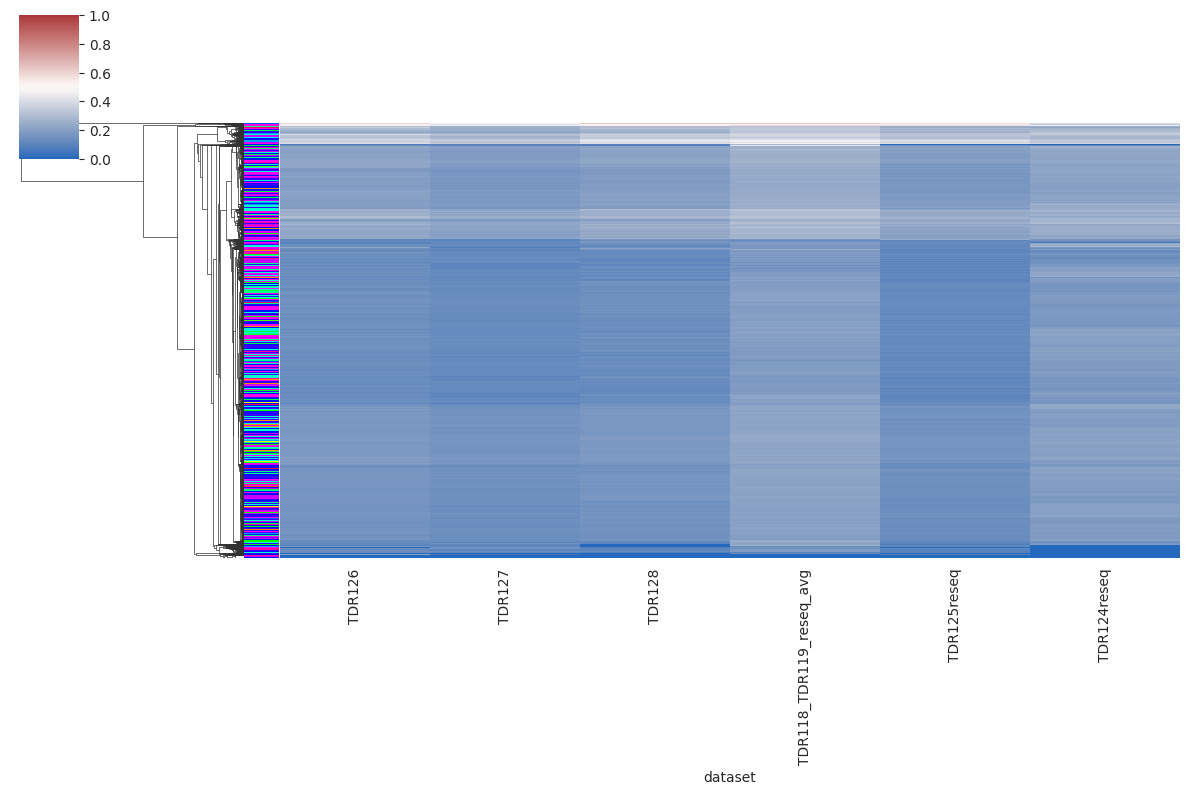

In [184]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster


# Step 1: Normalize the data (z-score for each gene)
# genes_by_dataset_zscored = genes_by_dataset_Somites.apply(zscore, axis=1)

# Step 2: Cluster the genes
# Check for non-finite values (NaN, Inf, -Inf) in the DataFrame
if not np.all(np.isfinite(genes_by_dataset_Somites)):
    # Replace non-finite values with zero or another suitable value
    genes_by_dataset_Somites = genes_by_dataset_Somites.replace([np.inf, -np.inf], np.nan)
    # You can fill NaN values with zero or some other imputation method
    genes_by_dataset_Somites = genes_by_dataset_Somites.fillna(0)

# Proceed with clustering now that the data contains only finite values
linkage_matrix = linkage(genes_by_dataset_Somites, method='ward')
gene_order = leaves_list(linkage_matrix)
genes_by_dataset_clustered = genes_by_dataset_Somites.iloc[gene_order]


# Step 3: Determine clusters for the side color bar
gene_clusters = fcluster(linkage_matrix, t=20, criterion='maxclust')
cluster_colors = sns.color_palette("hsv", np.unique(gene_clusters).max())
row_colors = pd.Series(gene_clusters, index=genes_by_dataset_clustered.index).map(dict(zip(np.unique(gene_clusters), cluster_colors)))

# Step 4: Generate the heatmap
sns.clustermap(genes_by_dataset_clustered,
               row_cluster=True, col_cluster=False,
               standard_scale=1, # Normalize across rows
               row_colors=row_colors, # Add cluster colors
               cmap="vlag", # Use a diverging color palette
               linewidths=0.0, # No lines between cells
               figsize=(12, 8), # Adjust the figure size to your data
               xticklabels=True, yticklabels=False) # Remove gene labels for clarity

plt.show()

### notes:
The adata.raw.X contains the "raw counts"

- Check out the notes from the "SeuratDisk::Convert"
AnnData/H5AD to h5Seurat
The AnnData/H5AD to h5Seurat conversion will try to automatically fill in datasets based on data presence. It works in the following manner:

Expression data
The expression matrices counts, data, and scale.data are filled by /X and /raw/X in the following manner:

- counts will be filled with /raw/X if present; otherwise, it will be filled with /X

- data will be filled with /raw/X if /raw/X is present and /X is dense; otherwise, it will be filled with /X

- scale.data will be filled with /X if it dense; otherwise, it will be empty

Feature names are taken from the feature-level metadata

In [ ]:
# we will use the gene.activity scores as the 
count_matrice = adata.raw.X.todense()

In [7]:
adata_sample = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/01_Signac_processed/TDR118reseq/TDR118_processed_RNA.h5ad")
adata_sample

AnnData object with n_obs × n_vars = 13614 × 32057
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'nCount_peaks_merged', 'nFeature_peaks_merged', 'SCT.weight', 'peaks_merged.weight', 'nCount_Gene.Activity', 'nFeature_Gene.Activity'
    var: 'features'
    obsm: 'X

### NOTES:
- h5ad for "RNA" has raw counts saved in adata.X
- h5ad for "ATAC" has raw counts saved in adata.raw.X